# Disease Classification

In this notebook, we will use text classification to automatically classify diseases based on the user's symptoms and feelings.

- **User_input**: user inputs tokenized without preprocessing
- **User_input_preprocessed**: user inputs tokenized with preprocessing
- **User_input_preprocessed_stem**: user inputs tokenized with preprocessing and stemming
- **User_input_preprocessed_lem** : user inputs tokenized with preprocessing and lematization

### Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, log_loss
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import joblib
from nltk.corpus import stopwords
from wordcloud import WordCloud
from hyperopt import hp, fmin, tpe, Trials, space_eval
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Reshape, Dense, Conv1D, GlobalMaxPooling1D, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from joblib import Parallel, delayed


#### Run with GPU


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Load

In [63]:
datapath = "Data/dataset.csv"

# Read dataset into a dataframe
data = pd.read_csv(datapath)

# Check loading
print("Data loaded successfully") if data.any(axis=None) else print("Error loading data")

Data loaded successfully


In [64]:
display(data)

Disease                                         User_input
0       Psoriasis  I have been experiencing a skin rash on my arm...
1       Psoriasis  My skin has been peeling, especially on my kne...
2       Psoriasis  I have been experiencing joint pain in my fing...
3       Psoriasis  There is a silver like dusting on my skin, esp...
4       Psoriasis  My nails have small dents or pits in them, and...
...           ...                                                ...
10599  Dermatitis  The discomfort in my skin has made it challeng...
10600  Dermatitis  The raw, sensitive skin from scratching has ma...
10601  Dermatitis  I feel like my skin is tearing apart, causing ...
10602  Dermatitis  Engaging in physical activities has become unb...
10603  Dermatitis  The pain in my skin has restricted me from enj...

[10604 rows x 2 columns]

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10604 entries, 0 to 10603
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     10604 non-null  object
 1   User_input  10604 non-null  object
dtypes: object(2)
memory usage: 165.8+ KB


In [66]:
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns." )
print(f"Dataset has {data['Disease'].nunique()} different diseases: {data['Disease'].unique()}.")

Dataset contains 10604 rows and 2 columns.
Dataset has 5 different diseases: ['Psoriasis' 'Melanoma' 'Urticaria' 'Lupus' 'Dermatitis'].


Psoriasis : 2184 samples
Melanoma : 2070 samples
Urticaria : 2216 samples
Lupus : 1868 samples
Dermatitis : 2266 samples


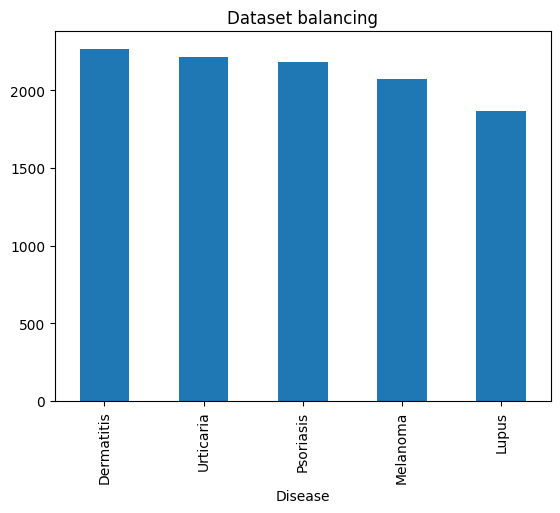

In [67]:
# Plot dataset balancing
data['Disease'].value_counts().plot(kind='bar', title='Dataset balancing')

# Print count for each disease
for disease in data['Disease'].unique():
    print(f"{disease} : {data[data['Disease'] == disease].shape[0]} samples")

## Model Evaluation

In [68]:
def evaluate(model, X_train, X_Test, y_train, y_test):
    # Train
    y_train_pred = model.predict(X_train)
    print("\033[1mTraining Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_train, y_train_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_train, y_train_pred, average='weighted'):.4f}")

    # Test
    y_test_pred = model.predict(X_Test)
    print("\n\033[1mTesting Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

    # Loss
    print("\n\033[1mLoss\033[0m")
    y_pred_proba = model.predict_proba(X_Test)
    # Calculate the log loss
    loss = log_loss(y_test, y_pred_proba)
    print(f"Log loss: {loss}")

    # Classification report train
    print("\n\033[1mClassification Report Train\033[0m")
    print(classification_report(y_train, y_train_pred))

    # Classification report test
    print("\n\033[1mClassification Report Test\033[0m")
    print(classification_report(y_test, y_test_pred))

    # Figure for confusion matrix and roc
    fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15, 5))

    # Confusion matrix
    conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=model.classes_)
    conf_matrix.plot(ax=ax1)

    # Roc Curve for each disease
    prediction = model.predict_proba(X_Test)
    falsepositive, truepositive, thresh = {}, {}, {}
    for i, disease in enumerate(model.classes_):
        falsepositive[disease], truepositive[disease], thresh[disease] = roc_curve(y_test, 
                                                                        prediction[:, i], 
                                                                        pos_label=disease)
    
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    for disease in model.classes_:
        ax2.plot(falsepositive[disease], truepositive[disease], label=disease)
    
    ax2.plot()

    #return test f1score
    return f1_score(y_test, y_test_pred, average='weighted')


def evaluate_dp(model, history, X, Y):
    print("\n\033[1mTesting Results\033[0m")
    loss, accuracy, f1_score = model.evaluate(X, Y, verbose=-1)
    print("Loss: ", loss)
    print("Accuracy: ", accuracy)
    print("F1-Score: ", f1_score)

    figure_dp, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'])
    ax1.plot()

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'])
    ax2.plot()


## Text Preprocessing

In [69]:
data['User_input_preprocessed'] = data['User_input']

- Remove stop words - Stop words are frequently occuring words in a language that are commonly omitted from NLP tasks due to their low significance for deciphering textual meaning.
- Remove pontuations
- Remove words with a single letter
- Transfrom all text in lower case

In [7]:
# Load english stop words using stopwords
# nltk.download('stopwords')

# Remove stop words
stop_words = stopwords.words('english')
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# Remove words with a sigle letter
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))
# Transform in lower case
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.lower()
# Remove special chars and pontuation like '.' ','
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
# Remove digits
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.replace('\d+', '')


## Data Visualization

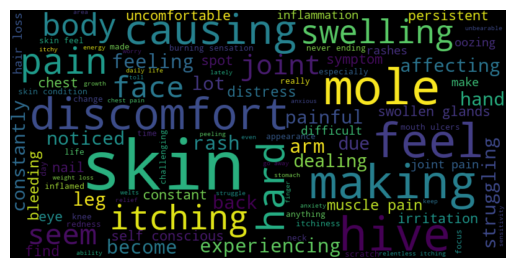

In [70]:
# General word cloud
word_list = " ".join(text for text in data['User_input'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Psoriasis

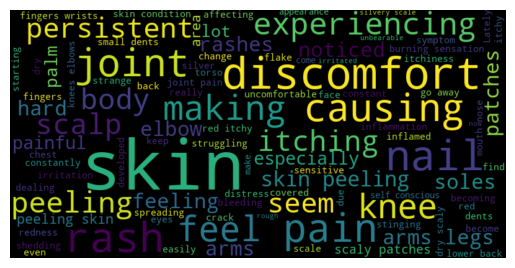

In [71]:
psoriasis = data[data['Disease'] == 'Psoriasis']

word_list = " ".join(text for text in psoriasis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Melanoma

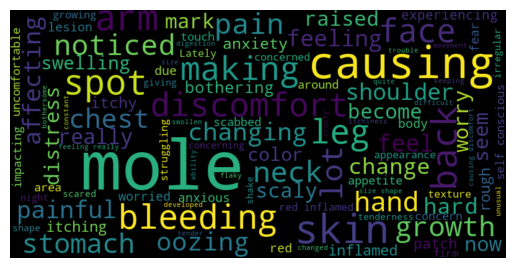

In [72]:
melanoma = data[data['Disease'] == 'Melanoma']

word_list = " ".join(text for text in melanoma['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Urticaria

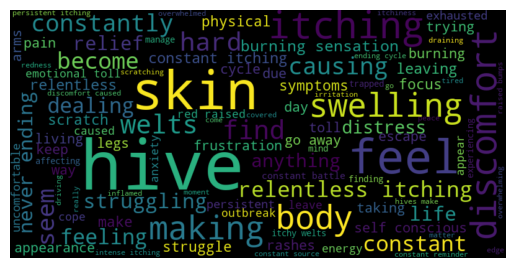

In [73]:
urticaria = data[data['Disease'] == 'Urticaria']

word_list = " ".join(text for text in urticaria['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Lupus

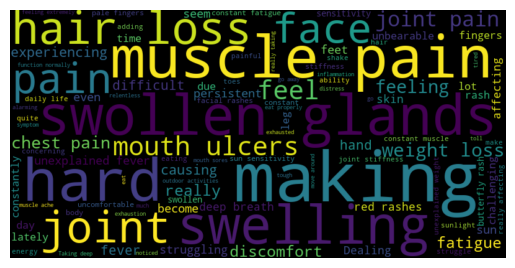

In [74]:
lupus = data[data['Disease'] == 'Lupus']

word_list = " ".join(text for text in lupus['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Dermatitis

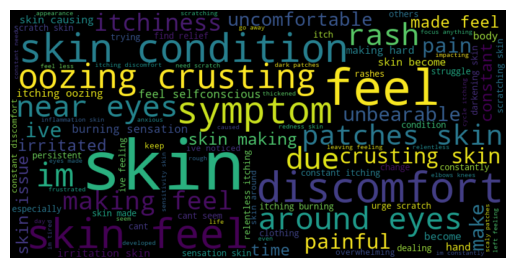

In [16]:
dermatitis = data[data['Disease'] == 'Dermatitis']

word_list = " ".join(text for text in dermatitis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Tokenization

In [17]:
# Tokenization by white space
#tokenizer = nltk.tokenize.WhitespaceTokenizer()
#data['User_input_token_whitespace'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))

# Tokenization by tree bank
#tokenizer = nltk.tokenize.TreebankWordDetokenizer()
#data['User_input_token_treebank'] = data['User_input_token_whitespace'].apply(lambda x: tokenizer.detokenize(x))

# Tokenization by word punct
#tokenizer = nltk.tokenize.WordPunctTokenizer()
#data['User_input_token_wordpunct'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))


## Stemming & Lamitization

### Stemming
Stemming is the process of reducing words to their word stems or roots by removing suffixes or prefixes. It uses simple rules to chop off ends of words, potentially resulting in non-real words.

### Lemmatization
Lemmatization, on the other hand, involves reducing words to their base or canonical form, known as the lemma, by considering the morphological analysis of the word. This process involves dictionary lookup to find the lemma, making it more accurate but potentially slower than stemming.

In [75]:
#nltk.download('wordnet')

In [76]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))
data['User_input'] = data['User_input'].apply(lambda x: tokenizer.tokenize(x))

In [77]:
# Stemming
stemmer = nltk.stem.PorterStemmer()
data['User_input_preprocessed_stem'] = data['User_input_preprocessed'].apply(lambda x: [stemmer.stem(word) for word in x])

In [78]:
# Lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
data['User_input_preprocessed_lem'] = data['User_input_preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [22]:
display(data)

Disease                                         User_input  \
0       Psoriasis  [I, have, been, experiencing, a, skin, rash, o...   
1       Psoriasis  [My, skin, has, been, peeling,, especially, on...   
2       Psoriasis  [I, have, been, experiencing, joint, pain, in,...   
3       Psoriasis  [There, is, a, silver, like, dusting, on, my, ...   
4       Psoriasis  [My, nails, have, small, dents, or, pits, in, ...   
...           ...                                                ...   
10329  Dermatitis  [The, discomfort, in, my, skin, has, made, it,...   
10330  Dermatitis  [The, raw,, sensitive, skin, from, scratching,...   
10331  Dermatitis  [I, feel, like, my, skin, is, tearing, apart,,...   
10332  Dermatitis  [Engaging, in, physical, activities, has, beco...   
10333  Dermatitis  [The, pain, in, my, skin, has, restricted, me,...   

                                 User_input_preprocessed  \
0      [experiencing, skin, rash, arms, legs, torso, ...   
1      [my, skin, peeling, especially, knees, elbows,...   
2      [experiencing, joint, pain, fingers, wrists, k...   
3      [there, silver, like, dusting, skin, especiall...   
4      [my, nails, small, dents, pits, them, often, f...   
...                                                  ...   
10329  [the, discomfort, skin, made, challenging, par...   
10330  [the, raw, sensitive, skin, scratching, made, ...   
10331  [feel, like, skin, tearing, apart, causing, ex...   
10332  [engaging, physical, activities, become, unbea...   
10333  [the, pain, skin, restricted, enjoying, hobbie...   

                            User_input_preprocessed_stem  \
0      [experienc, skin, rash, arm, leg, torso, past,...   
1      [my, skin, peel, especi, knee, elbow, scalp, t...   
2      [experienc, joint, pain, finger, wrist, knee, ...   
3      [there, silver, like, dust, skin, especi, lowe...   
4      [my, nail, small, dent, pit, them, often, feel...   
...                                                  ...   
10329  [the, discomfort, skin, made, challeng, partak...   
10330  [the, raw, sensit, skin, scratch, made, unbear...   
10331  [feel, like, skin, tear, apart, caus, excruci,...   
10332  [engag, physic, activ, becom, unbear, due, sen...   
10333  [the, pain, skin, restrict, enjoy, hobbi, invo...   

                             User_input_preprocessed_lem  
0      [experiencing, skin, rash, arm, leg, torso, pa...  
1      [my, skin, peeling, especially, knee, elbow, s...  
2      [experiencing, joint, pain, finger, wrist, kne...  
3      [there, silver, like, dusting, skin, especiall...  
4      [my, nail, small, dent, pit, them, often, feel...  
...                                                  ...  
10329  [the, discomfort, skin, made, challenging, par...  
10330  [the, raw, sensitive, skin, scratching, made, ...  
10331  [feel, like, skin, tearing, apart, causing, ex...  
10332  [engaging, physical, activity, become, unbeara...  
10333  [the, pain, skin, restricted, enjoying, hobby,...  

[10334 rows x 5 columns]

## Embeddings

### Bag of Words (BoW)
Is a technique in NLP that represents text as a frequency count of words in a corpus, creating a numerical vector representing the corpus

In [79]:
boW = CountVectorizer(stop_words='english')

bow_normal = boW.fit(data['User_input'].apply(' '.join))

bow_preprocessed = boW.fit(data["User_input_preprocessed"].apply(' '.join))

bow_lem = boW.fit(data['User_input_preprocessed_lem'].apply(' '.join))

bow_stem = boW.fit(data['User_input_preprocessed_stem'].apply(' '.join))


We think that to understand the symptoms is important to use n-grams

In [15]:
bow_ngram = CountVectorizer(stop_words='english', ngram_range=(1,3))

bow_ngram_normal = bow_ngram.fit(data['User_input'].apply(' '.join))

bow_ngram_preprocessed = bow_ngram.fit(data["User_input_preprocessed"].apply(' '.join))

bow_ngram_lem = bow_ngram.fit(data['User_input_preprocessed_lem'].apply(' '.join))

bow_ngram_stem = bow_ngram.fit(data['User_input_preprocessed_stem'].apply(' '.join))


### TF-IDF

In [80]:
tf_idf = TfidfVectorizer()

tf_idf_normal = tf_idf.fit(data['User_input'].apply(' '.join))

tf_idf_preprocessed = tf_idf.fit(data['User_input_preprocessed'].apply(' '.join))

tf_idf_lem = tf_idf.fit(data['User_input_preprocessed_lem'].apply(' '.join))

tf_idf_stem = tf_idf.fit(data['User_input_preprocessed_stem'].apply(' '.join))

# Save fited vectorizer
#joblib.dump(tf_idf_stem, 'Vectorizer/tfidf_stem.pkl')
#joblib.dump(tf_idf_lem, 'Vectorizer/tfidf_lem.pkl')

In [81]:
tf_idf_ngram = TfidfVectorizer(ngram_range=(1,3))

tf_idf_ngram_normal = tf_idf_ngram.fit(data['User_input'].apply(' '.join))

tf_idf_ngram_preprocessed = tf_idf_ngram.fit(data['User_input_preprocessed'].apply(' '.join))

tf_idf_ngram_lem = tf_idf_ngram.fit(data['User_input_preprocessed_lem'].apply(' '.join))

tf_idf_ngram_stem = tf_idf_ngram.fit(data['User_input_preprocessed_stem'].apply(' '.join))

## Data spliting

Once the dataset was created by the group, we decided to create a balanced dataset to make the next steps easier.

In [82]:
# Split dataset into training and testing sets
# Create a test and a train dataframe
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Check splitting
print(f"Train dataset contains {train.shape[0]} rows and {train.shape[1]} columns.")
print(f"Test dataset contains {test.shape[0]} rows and {test.shape[1]} columns.")

Train dataset contains 8483 rows and 5 columns.
Test dataset contains 2121 rows and 5 columns.


In [18]:
display(train)

Disease                                         User_input  \
4880  Urticaria  [I'm, struggling, to, find, moments, of, peace...   
6651      Lupus  [My, sensitivity, to, sunlight, is, causing, m...   
6451  Urticaria  [The, hives, have, disrupted, every, aspect, o...   
4157   Melanoma  [I've, recently, noticed, this, growth, on, my...   
828   Psoriasis  [I, struggle, with, painful, swelling, in, my,...   
...         ...                                                ...   
5734  Urticaria  [The, hives, on, my, skin, have, caused, such,...   
5191  Urticaria  [The, itching, and, swelling, have, become, a,...   
5390  Urticaria  [It, feels, like, I'm, living, in, a, body, th...   
860   Psoriasis  [I'm, frustrated, by, the, visible, scales, th...   
7270      Lupus  [The, muscle, pain, and, persistent, fever, ha...   

                                User_input_preprocessed  \
4880  [I'm, struggling, to, find, moments, of, peace...   
6651  [My, sensitivity, to, sunlight, is, causing, m...   
6451  [The, hives, have, disrupted, every, aspect, o...   
4157  [I've, recently, noticed, this, growth, on, my...   
828   [I, struggle, with, painful, swelling, in, my,...   
...                                                 ...   
5734  [The, hives, on, my, skin, have, caused, such,...   
5191  [The, itching, and, swelling, have, become, a,...   
5390  [It, feels, like, I'm, living, in, a, body, th...   
860   [I'm, frustrated, by, the, visible, scales, th...   
7270  [The, muscle, pain, and, persistent, fever, ha...   

                           User_input_preprocessed_stem  \
4880  [i'm, struggl, to, find, moment, of, peac, ami...   
6651  [my, sensit, to, sunlight, is, caus, me, a, lo...   
6451  [the, hive, have, disrupt, everi, aspect, of, ...   
4157  [i'v, recent, notic, thi, growth, on, my, leg,...   
828   [i, struggl, with, pain, swell, in, my, joint,...   
...                                                 ...   
5734  [the, hive, on, my, skin, have, caus, such, in...   
5191  [the, itch, and, swell, have, becom, a, consta...   
5390  [it, feel, like, i'm, live, in, a, bodi, that'...   
860   [i'm, frustrat, by, the, visibl, scale, that, ...   
7270  [the, muscl, pain, and, persist, fever, have, ...   

                            User_input_preprocessed_lem  
4880  [I'm, struggling, to, find, moment, of, peace,...  
6651  [My, sensitivity, to, sunlight, is, causing, m...  
6451  [The, hive, have, disrupted, every, aspect, of...  
4157  [I've, recently, noticed, this, growth, on, my...  
828   [I, struggle, with, painful, swelling, in, my,...  
...                                                 ...  
5734  [The, hive, on, my, skin, have, caused, such, ...  
5191  [The, itching, and, swelling, have, become, a,...  
5390  [It, feel, like, I'm, living, in, a, body, tha...  
860   [I'm, frustrated, by, the, visible, scale, tha...  
7270  [The, muscle, pain, and, persistent, fever, ha...  

[8267 rows x 5 columns]

#### Define X

##### BoW

In [83]:
# without preprocessing
X_train_bow_noproc = bow_normal.transform(train['User_input'].apply(' '.join))
X_test_bow_noproc = bow_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_bow_proc = bow_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_bow_proc = bow_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_bow_stem = bow_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_bow_stem = bow_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_bow_lem = bow_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_bow_lem = bow_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

##### Bow Ngram

In [84]:
# without preprocessing
X_train_ngram_noproc = bow_ngram_normal.transform(train['User_input'].apply(' '.join))
X_test_ngram_noproc = bow_ngram_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_ngram_proc = bow_ngram_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_ngram_proc = bow_ngram_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_ngram_stem = bow_ngram_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_ngram_stem = bow_ngram_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_ngram_lem = bow_ngram_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_ngram_lem = bow_ngram_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))


##### TF-IDF

In [85]:
# without preprocessing
X_train_tfidf_noproc = tf_idf_normal.transform(train['User_input'].apply(' '.join))
X_test_tfidf_noproc = tf_idf_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_tfidf_proc = tf_idf_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_tfidf_proc = tf_idf_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_tfidf_stem = tf_idf_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_tfidf_stem = tf_idf_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_tfidf_lem = tf_idf_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_tfidf_lem = tf_idf_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

In [86]:
features = tf_idf_stem.get_feature_names_out()

weights = np.asarray(X_train_tfidf_stem.mean(axis=0)).ravel()

features_weights = list(zip(features, weights))
features_weights.sort(key = lambda x: x[1], reverse = True)

top_features = features_weights[:20]
for feature, weight in top_features:
    print(f"Feature: {feature}, Weight: {weight}")

Feature: my, Weight: 0.0715221792208926
Feature: the, Weight: 0.07098214769312906
Feature: and, Weight: 0.07028479571708236
Feature: on, Weight: 0.05299858504767912
Feature: skin, Weight: 0.047182159527181265
Feature: to, Weight: 0.045415510282943224
Feature: me, Weight: 0.04424409964382864
Feature: of, Weight: 0.042683896937965496
Feature: is, Weight: 0.04094055430803648
Feature: been, Weight: 0.03937187630675558
Feature: feel, Weight: 0.037216803389683105
Feature: that, Weight: 0.034888874468209256
Feature: it, Weight: 0.0324667259523578
Feature: are, Weight: 0.03113712440949022
Feature: in, Weight: 0.030354555855530516
Feature: have, Weight: 0.02908834177751971
Feature: with, Weight: 0.028830180996180094
Feature: pain, Weight: 0.028704202303489638
Feature: ha, Weight: 0.026963810987522676
Feature: mole, Weight: 0.02546045649181321


##### TF-IDF N-gram

In [23]:
# without preprocessing
X_train_tfidf_ngram_noproc = tf_idf_ngram_normal.transform(train['User_input'].apply(' '.join))
X_test_tfidf_ngram_noproc = tf_idf_ngram_normal.transform(test['User_input'].apply(' '.join))

# With preprocessing
X_train_tfidf_ngram_proc = tf_idf_ngram_preprocessed.transform(train['User_input_preprocessed'].apply(' '.join))
X_test_tfidf_ngram_proc = tf_idf_ngram_preprocessed.transform(test['User_input_preprocessed'].apply(' '.join))

# With stem
X_train_tfidf_ngram_stem = tf_idf_ngram_stem.transform(train['User_input_preprocessed_stem'].apply(' '.join))
X_test_tfidf_ngram_stem = tf_idf_ngram_stem.transform(test['User_input_preprocessed_stem'].apply(' '.join))

# With lemmatization
X_train_tfidf_ngram_lem = tf_idf_ngram_lem.transform(train['User_input_preprocessed_lem'].apply(' '.join))
X_test_tfidf_ngram_lem = tf_idf_ngram_lem.transform(test['User_input_preprocessed_lem'].apply(' '.join))

NameError: name 'tf_idf_ngram_normal' is not defined

#### Define Y

In [87]:
y_train = train['Disease']
y_test = test['Disease']

## Text classification

### Machine Learning

#### Logistic Regression

**Important Parameters:**
- Solver
- Penalty
- C
- Max_Iter

In [71]:
best_score_lr = 0
best_modeltype_lr = ""
best_model = None

##### Hyperopt

In [20]:
def hyperopt_lr(X_train):
    space = {
        'solver': hp.choice('solver', ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']),
        'penalty': hp.choice('penalty', ['l2']),
        'C': hp.uniform('C', 1.0, 10.0),
        'max_iter': hp.choice('max_iter', [1, 2, 5, 10, 20, 50, 100, 200, 500])
    }

    def objective(params):
        clf = LogisticRegression(solver=params['solver'], penalty=params['penalty'], C=params['C'],
                                 max_iter=params['max_iter'])
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return -score

    tpe_algorithm = tpe.suggest

    trials = Trials()

    best = fmin(fn=objective,
                space=space,
                algo=tpe_algorithm,
                max_evals=50,
                trials=trials)

    best_params = space_eval(space, best)
    print("Best hyperparameters:", best_params)
    return best_params


##### Grid Search

In [21]:
def grid_search_lr(X_train):
    lr = LogisticRegression()

    param_grid = [
        {
            'solver': ['liblinear'],
            'penalty': ['l1','l2'],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['lbfgs','newton-cg','sag'],
            'penalty': ['l2',],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga'],
            'penalty': ['l1','l2'],
            'C': np.arange(1.0, 10.0, 1.0),
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga'],
            'penalty': ['elasticnet'],
            'C': np.arange(1.0, 10.0, 1.0),
            'l1_ratio': [0.1, 0.5, 0.9],  # Add l1_ratio here
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        },
        {
            'solver': ['saga', 'sag', 'newton-cg', 'lbfgs'],
            'penalty': [None],
            'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
        }
    ]

    grid = GridSearchCV(estimator=lr, param_grid=param_grid, verbose=0, n_jobs=-1, cv=2, scoring='accuracy')
    grid.fit(X_train, y_train)

    print(f"Best parameters: {grid.best_params_}")
    return grid.best_params_


##### Run Model

In [74]:
def model_lr(best_param, X_train, X_test, model_type):
    global best_score_lr, best_modeltype_lr, best_model
    
    lr = LogisticRegression(solver=best_param['solver'], penalty=best_param['penalty'], C=best_param['C'], max_iter=best_param['max_iter'])
    lr.fit(X_train, y_train)
    score = evaluate(lr, X_train, X_test, y_train, y_test)
    
    if score > best_score_lr:
        best_score_lr = score
        best_modeltype_lr = model_type
        best_model = lr

##### Without Preprocessing

In [75]:
name = "LR_withoutyproc_"

**BoW** 

100%|██████████| 50/50 [00:11<00:00,  4.18trial/s, best loss: -0.7331549174817542]
Best hyperparameters: {'C': 3.424174241178451, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Training Results
Accuracy Score: 0.7812
Specificity Score: 0.7812
Precision Score: 0.7881
F1 Score: 0.7802

Testing Results
Accuracy Score: 0.7175
Specificity Score: 0.7175
Precision Score: 0.7250
F1 Score: 0.7168

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.65      0.72      0.68      1803
       Lupus       0.88      0.88      0.88      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.78      0.57      0.66      1668
   Urticaria       0.67      0.77      0.72      1764

    accuracy                           0.78      8267
   macro avg       0.80      0.79      0.79      8267
weighted avg       0.79      0.78      0.78      8267


Classification Report Test
              precision    recall  f1-score   support

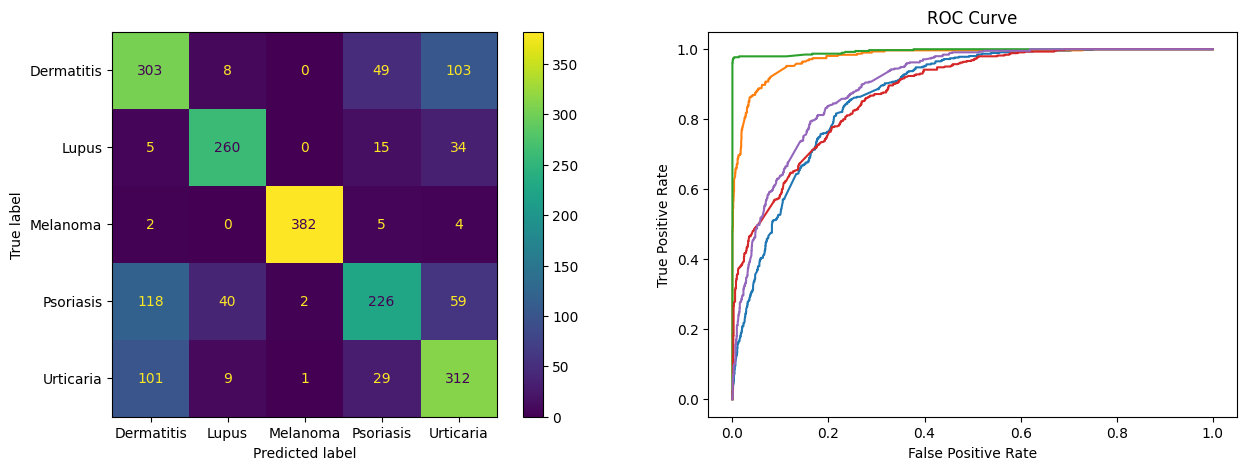

In [76]:
best_params = hyperopt_lr(X_train_bow_noproc)
model_lr(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

In [77]:
best_params = grid_search_lr(X_train_bow_noproc)
model_lr(best_params, X_train_bow_noproc, X_test_bow_noproc, name + "bow")

KeyboardInterrupt: 

**BoW n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_noproc)
model_lr(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "bow_ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_noproc)
model_lr(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "bow_ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_noproc)
model_lr(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_noproc)
model_lr(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_ngram_noproc)
model_lr(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_ngram_noproc)
model_lr(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

##### With Preprocessing

In [ ]:
name = "LR_withproc_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_proc)
model_lr(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_proc)
model_lr(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**BoW n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_proc)
model_lr(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "bow_ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_proc)
model_lr(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "bow_ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_proc)
model_lr(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_proc)
model_lr(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_ngram_proc)
model_lr(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_ngram_proc)
model_lr(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

##### With lamatization

In [ ]:
name = "LR_lem_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_lem)
model_lr(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_lem)
model_lr(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**BoW n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_lem)
model_lr(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "bow_ngram")

In [ ]:
best_params = grid_search_lr(X_train_bow_lem)
model_lr(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "bow_ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_lem)
model_lr(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_lem)
model_lr(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_ngram_lem)
model_lr(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_ngram_lem)
model_lr(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

##### With stemming

In [ ]:
name = "LR_stem_"

**BoW** 

In [ ]:
best_params = hyperopt_lr(X_train_bow_stem)
model_lr(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

In [ ]:
best_params = grid_search_lr(X_train_bow_stem)
model_lr(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**BoW n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_ngram_stem)
model_lr(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "bow_ngram")

In [ ]:
best_params = grid_search_lr(X_train_ngram_stem)
model_lr(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "bow_ngram")

**TF-IDF**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_stem)
model_lr(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_stem)
model_lr(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

**TF-IDF n-grams**

In [ ]:
best_params = hyperopt_lr(X_train_tfidf_ngram_stem)
model_lr(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

In [ ]:
best_params = grid_search_lr(X_train_tfidf_ngram_stem)
model_lr(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

##### Save best model

In [ ]:
joblib.dump(best_model,f'Models/LR/{best_modeltype_lr}.pkl')
print(best_score_lr)

#### Naive Bayes

**Important Parameters:**
- Alpha
- Fit Prior
- Class Prior

In [22]:
best_score_nb = 0
best_modeltype_nb = ""
best_model = None

##### Random Search ####

In [26]:
def random_search_nb(X_train):
    param_grid = {
        'alpha': np.random.uniform(0.0, 2.0, 50),
        'fit_prior': [True, False],
        'class_prior': [None] + [np.random.dirichlet(np.ones(np.unique(y_train).shape[0])) for _ in range(50)]
    }
    
    best_score = float('-inf')
    best_params = None
    
    def evaluate_params(params):
        clf = MultinomialNB(alpha=params['alpha'], fit_prior=params['fit_prior'], class_prior=params['class_prior'])
        score = cross_val_score(clf, X_train, y_train, cv=5).mean()
        return score

    num_iterations = 50
    for _ in range(num_iterations):
        params = {k: np.random.choice(v) if k != 'class_prior' else v[np.random.randint(len(v))] for k, v in param_grid.items()}
        score = evaluate_params(params)
        if score > best_score:
            best_score = score
            best_params = params
    
    print("Best hyperparameters:", best_params)
    return best_params


##### Run Model

In [27]:
def model_nb(best_param, X_train, X_test, model_type):

    global best_score_nb, best_modeltype_nb, best_model

    nb = MultinomialNB(alpha=best_param['alpha'], fit_prior=best_param['fit_prior'], class_prior=best_param['class_prior'])
    nb.fit(X_train, y_train)
    score = evaluate(nb, X_train, X_test, y_train, y_test)
    if score > best_score_nb:
        best_score_nb = score
        best_modeltype_nb = model_type
        best_model = nb

##### Without Preprocessing

In [37]:
name = "NB_withoutyproc_"

**BoW** 

Best hyperparameters: {'alpha': 0.7044559937296238, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.7376
Specificity Score: 0.7376
Precision Score: 0.7442
F1 Score: 0.7345

Testing Results
Accuracy Score: 0.6817
Specificity Score: 0.6817
Precision Score: 0.6892
F1 Score: 0.6786

Loss
Log loss: 0.7594235320445649

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.57      0.70      0.62      1803
       Lupus       0.83      0.85      0.84      1355
    Melanoma       0.93      0.98      0.95      1677
   Psoriasis       0.74      0.50      0.60      1668
   Urticaria       0.69      0.69      0.69      1764

    accuracy                           0.74      8267
   macro avg       0.75      0.74      0.74      8267
weighted avg       0.74      0.74      0.73      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.51      0.63      0.56       463
    

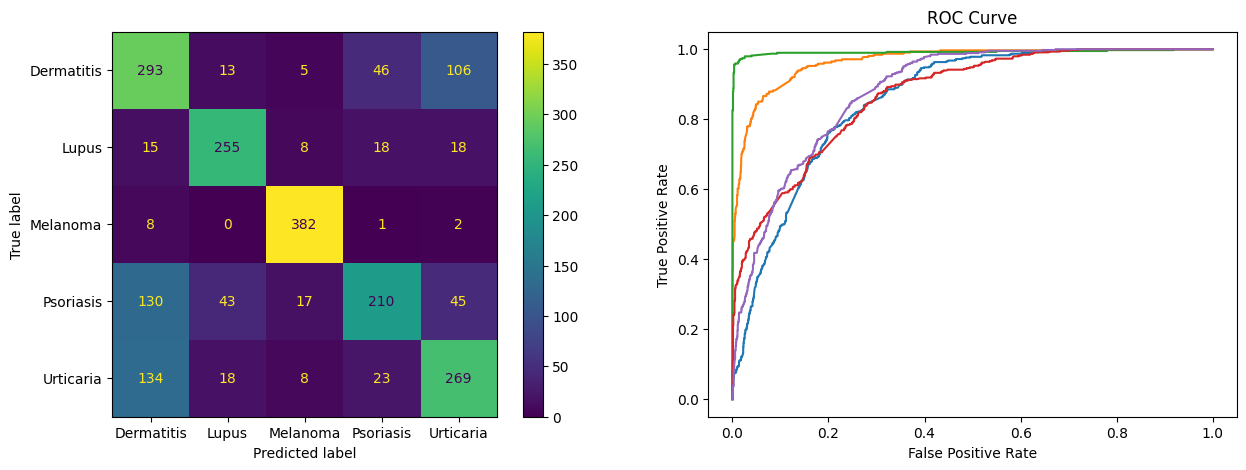

In [38]:
best_params = random_search_nb(X_train_bow_noproc)
model_nb(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

**BoW n-grams**

Best hyperparameters: {'alpha': 1.2859201522941381, 'fit_prior': False, 'class_prior': array([0.26022705, 0.18083391, 0.09753381, 0.18545709, 0.27594814])}
Training Results
Accuracy Score: 0.7581
Specificity Score: 0.7581
Precision Score: 0.7739
F1 Score: 0.7524

Testing Results
Accuracy Score: 0.7015
Specificity Score: 0.7015
Precision Score: 0.7162
F1 Score: 0.6973

Loss
Log loss: 0.796928094905649

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.63      0.72      0.67      1803
       Lupus       0.82      0.87      0.85      1355
    Melanoma       0.96      0.98      0.97      1677
   Psoriasis       0.85      0.46      0.60      1668
   Urticaria       0.64      0.78      0.70      1764

    accuracy                           0.76      8267
   macro avg       0.78      0.76      0.76      8267
weighted avg       0.77      0.76      0.75      8267


Classification Report Test
              precision    recall  f1-score   supp

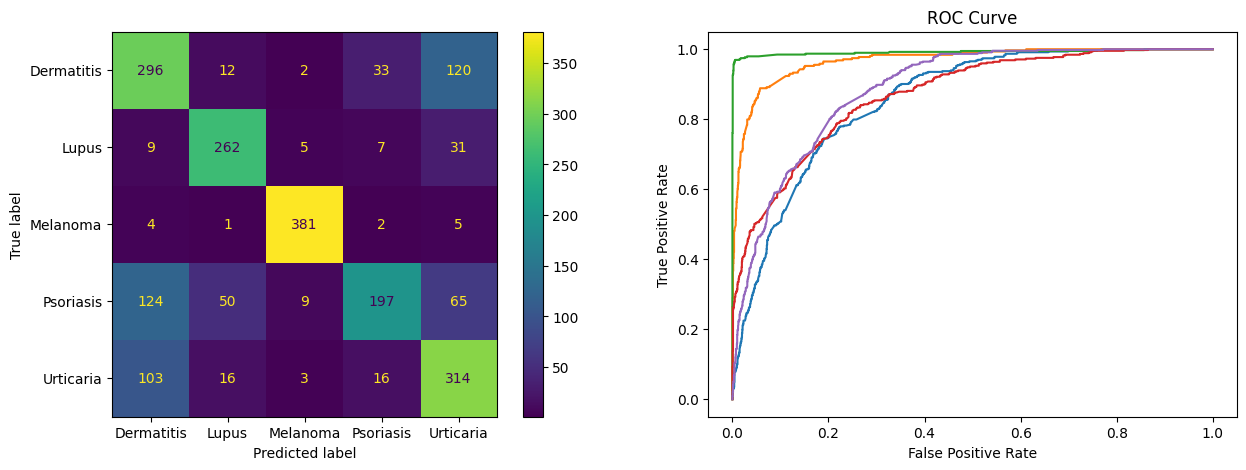

In [39]:
best_params = random_search_nb(X_train_ngram_noproc)
model_nb(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "bow_ngram")

**TF-IDF**

Best hyperparameters: {'alpha': 0.1231882264146662, 'fit_prior': False, 'class_prior': array([0.27582764, 0.34423144, 0.03861587, 0.09502644, 0.24629861])}
Training Results
Accuracy Score: 0.7091
Specificity Score: 0.7091
Precision Score: 0.7710
F1 Score: 0.6983

Testing Results
Accuracy Score: 0.6628
Specificity Score: 0.6628
Precision Score: 0.7329
F1 Score: 0.6553

Loss
Log loss: 0.9312120207435084

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.55      0.78      0.65      1803
       Lupus       0.64      0.94      0.76      1355
    Melanoma       1.00      0.80      0.89      1677
   Psoriasis       0.95      0.32      0.48      1668
   Urticaria       0.71      0.74      0.72      1764

    accuracy                           0.71      8267
   macro avg       0.77      0.72      0.70      8267
weighted avg       0.77      0.71      0.70      8267


Classification Report Test
              precision    recall  f1-score   sup

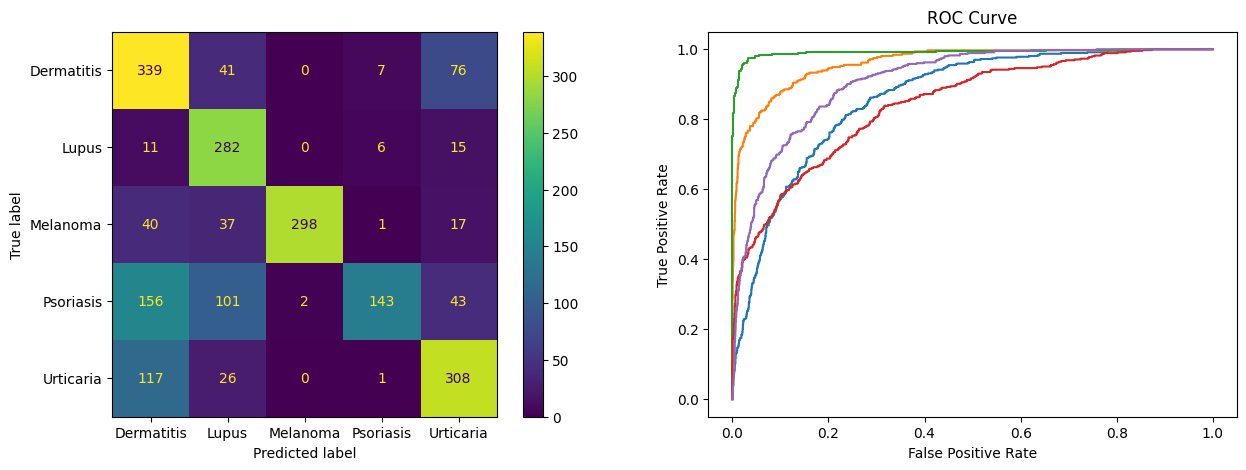

In [40]:
best_params = random_search_nb(X_train_tfidf_noproc)
model_nb(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'alpha': 0.2848309400913609, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.7864
Specificity Score: 0.7864
Precision Score: 0.7991
F1 Score: 0.7848

Testing Results
Accuracy Score: 0.7315
Specificity Score: 0.7315
Precision Score: 0.7464
F1 Score: 0.7310

Loss
Log loss: 0.7356287746986518

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.68      0.77      0.72      1803
       Lupus       0.95      0.74      0.83      1355
    Melanoma       0.88      0.98      0.93      1677
   Psoriasis       0.83      0.60      0.70      1668
   Urticaria       0.70      0.83      0.76      1764

    accuracy                           0.79      8267
   macro avg       0.81      0.78      0.79      8267
weighted avg       0.80      0.79      0.78      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.59      0.70      0.64       463
    

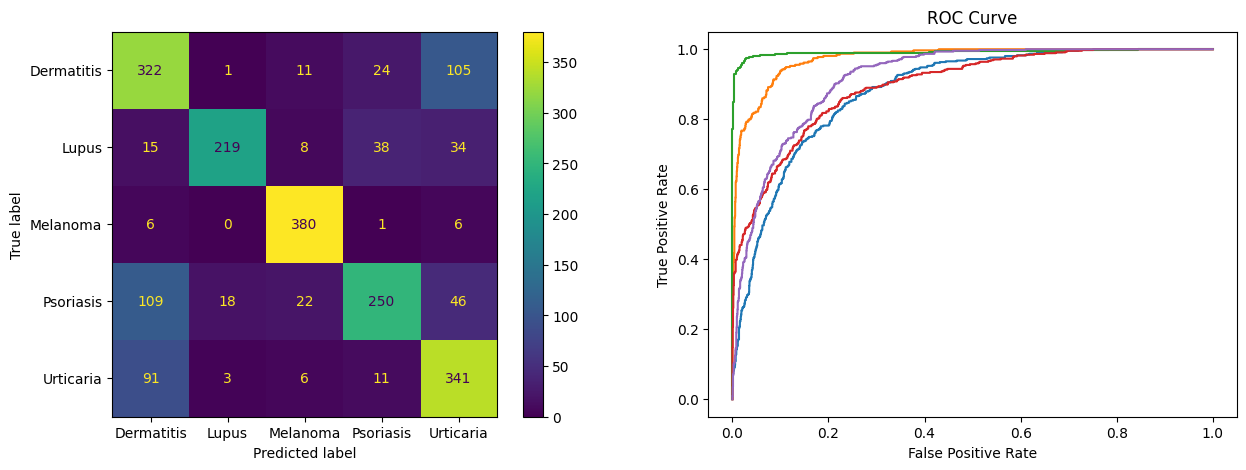

In [41]:
best_params = random_search_nb(X_train_tfidf_ngram_noproc)
model_nb(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

##### With Preprocessing

In [28]:
name = "NB_withproc_"

**BoW** 

Best hyperparameters: {'alpha': 1.0235105479082023, 'fit_prior': False, 'class_prior': array([0.22123949, 0.2275347 , 0.06814009, 0.14618448, 0.33690124])}
Training Results
Accuracy Score: 0.7273
Specificity Score: 0.7273
Precision Score: 0.7450
F1 Score: 0.7211

Testing Results
Accuracy Score: 0.6880
Specificity Score: 0.6880
Precision Score: 0.7069
F1 Score: 0.6816

Loss
Log loss: 0.775373650506042

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.63      0.56      0.59      1803
       Lupus       0.78      0.87      0.82      1355
    Melanoma       0.98      0.96      0.97      1677
   Psoriasis       0.79      0.45      0.58      1668
   Urticaria       0.57      0.83      0.68      1764

    accuracy                           0.73      8267
   macro avg       0.75      0.73      0.73      8267
weighted avg       0.74      0.73      0.72      8267


Classification Report Test
              precision    recall  f1-score   supp

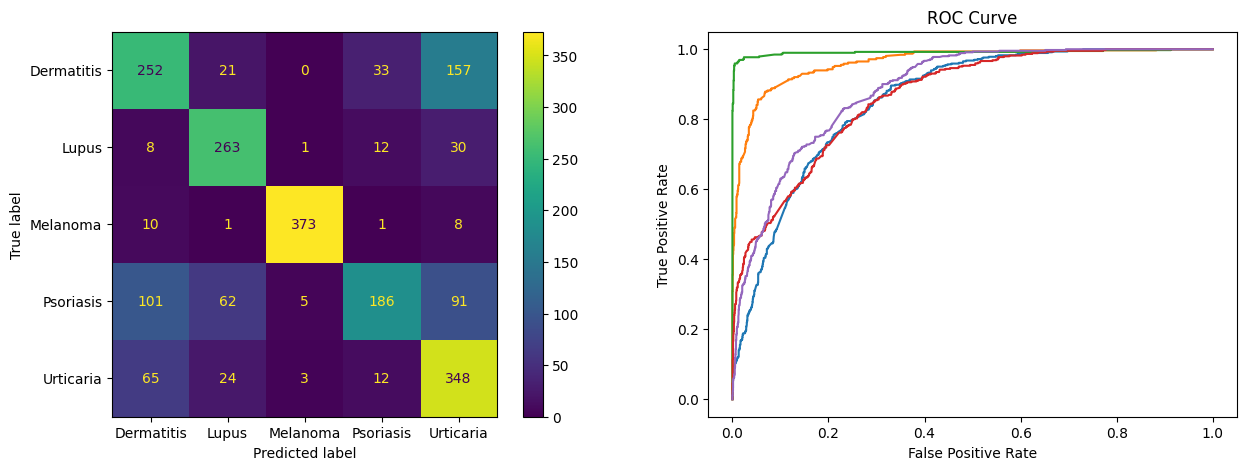

In [29]:
best_params = random_search_nb(X_train_bow_proc)
model_nb(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**BoW n-grams**

Best hyperparameters: {'alpha': 0.2522780320810747, 'fit_prior': False, 'class_prior': array([0.33083353, 0.0515507 , 0.003993  , 0.34570476, 0.26791801])}
Training Results
Accuracy Score: 0.7062
Specificity Score: 0.7062
Precision Score: 0.7362
F1 Score: 0.7132

Testing Results
Accuracy Score: 0.6594
Specificity Score: 0.6594
Precision Score: 0.6910
F1 Score: 0.6671

Loss
Log loss: 0.8994915293995586

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.58      0.65      0.61      1803
       Lupus       0.94      0.63      0.75      1355
    Melanoma       1.00      0.93      0.96      1677
   Psoriasis       0.53      0.68      0.60      1668
   Urticaria       0.68      0.63      0.66      1764

    accuracy                           0.71      8267
   macro avg       0.75      0.70      0.72      8267
weighted avg       0.74      0.71      0.71      8267


Classification Report Test
              precision    recall  f1-score   sup

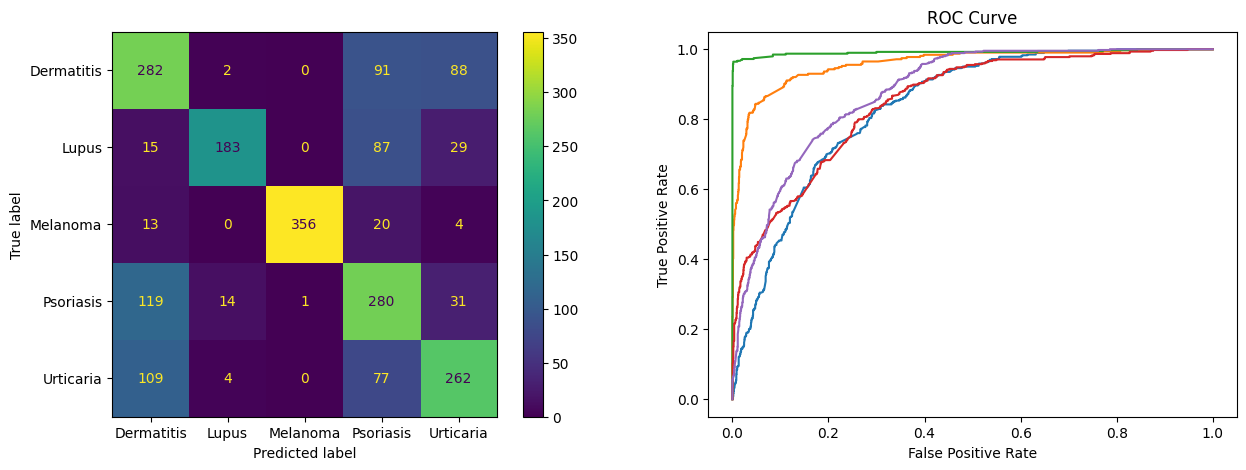

In [30]:
best_params = random_search_nb(X_train_ngram_proc)
model_nb(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

Best hyperparameters: {'alpha': 1.5827481928149039, 'fit_prior': False, 'class_prior': None}
Training Results
Accuracy Score: 0.7437
Specificity Score: 0.7437
Precision Score: 0.7421
F1 Score: 0.7399

Testing Results
Accuracy Score: 0.7030
Specificity Score: 0.7030
Precision Score: 0.7025
F1 Score: 0.6987

Loss
Log loss: 0.8256073620165968

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.64      0.61      0.63      1803
       Lupus       0.81      0.84      0.82      1355
    Melanoma       0.90      0.98      0.94      1677
   Psoriasis       0.74      0.58      0.65      1668
   Urticaria       0.65      0.74      0.69      1764

    accuracy                           0.74      8267
   macro avg       0.75      0.75      0.75      8267
weighted avg       0.74      0.74      0.74      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.58      0.58      0.58       463
   

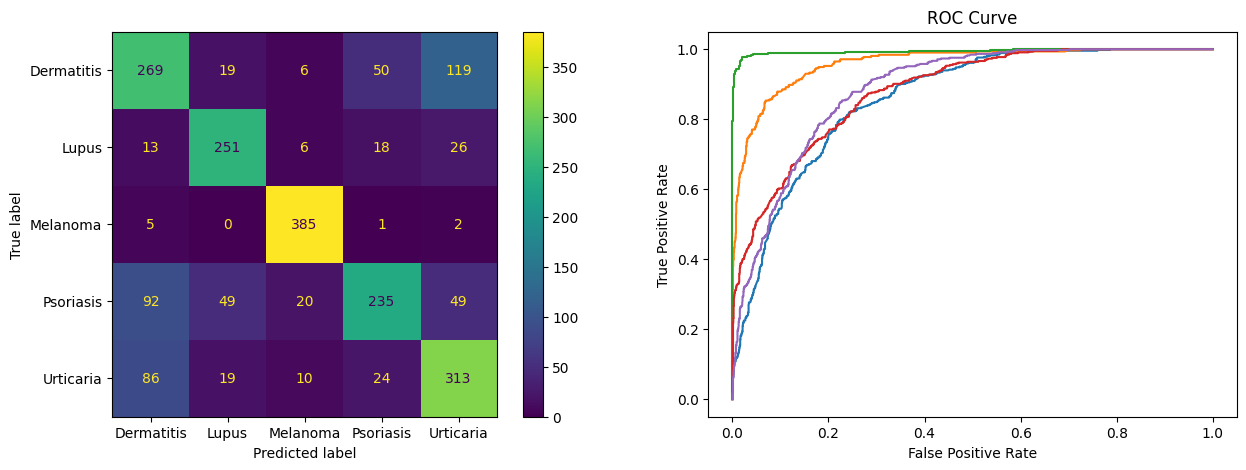

In [45]:
best_params = random_search_nb(X_train_tfidf_proc)
model_nb(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'alpha': 1.462893132055172, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.7890
Specificity Score: 0.7890
Precision Score: 0.7967
F1 Score: 0.7896

Testing Results
Accuracy Score: 0.7092
Specificity Score: 0.7092
Precision Score: 0.7188
F1 Score: 0.7101

Loss
Log loss: 0.8051275454231327

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.67      0.72      0.70      1803
       Lupus       0.91      0.80      0.85      1355
    Melanoma       0.95      0.99      0.97      1677
   Psoriasis       0.81      0.66      0.73      1668
   Urticaria       0.68      0.78      0.73      1764

    accuracy                           0.79      8267
   macro avg       0.80      0.79      0.79      8267
weighted avg       0.80      0.79      0.79      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.55      0.62      0.58       463
     

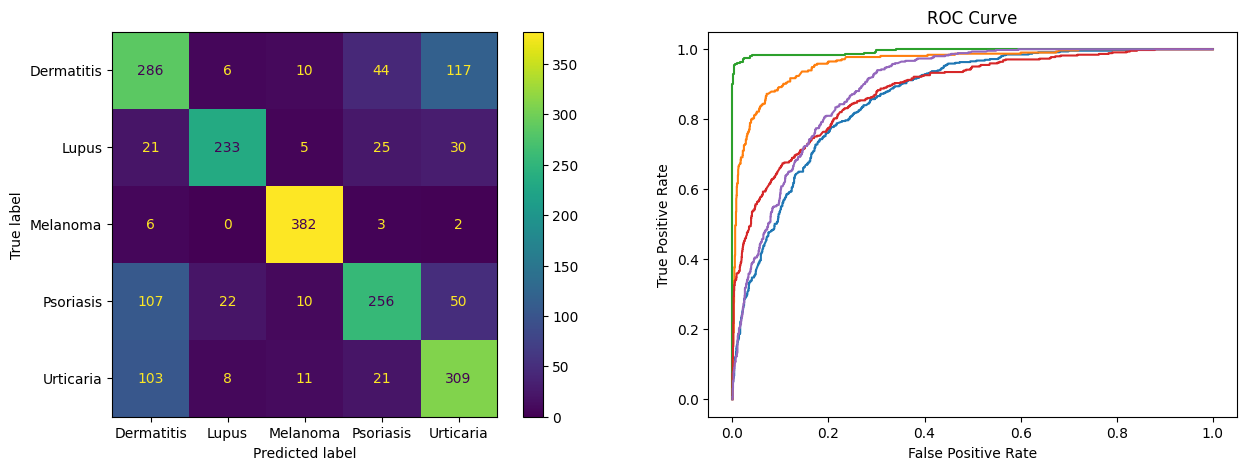

In [46]:
best_params = random_search_nb(X_train_tfidf_ngram_proc)
model_nb(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

##### With lematization

In [47]:
name = "NB_lem_"

**BoW** 

Best hyperparameters: {'alpha': 0.9797863913446936, 'fit_prior': True, 'class_prior': array([0.24379365, 0.25257986, 0.14447813, 0.18948913, 0.16965923])}
Training Results
Accuracy Score: 0.8262
Specificity Score: 0.8262
Precision Score: 0.8317
F1 Score: 0.8253

Testing Results
Accuracy Score: 0.7987
Specificity Score: 0.7987
Precision Score: 0.8050
F1 Score: 0.7976

Loss
Log loss: 0.5368956612557911

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.69      0.80      0.74      1803
       Lupus       0.82      0.92      0.86      1355
    Melanoma       0.95      0.95      0.95      1677
   Psoriasis       0.83      0.65      0.73      1668
   Urticaria       0.88      0.83      0.85      1764

    accuracy                           0.83      8267
   macro avg       0.83      0.83      0.83      8267
weighted avg       0.83      0.83      0.83      8267


Classification Report Test
              precision    recall  f1-score   supp

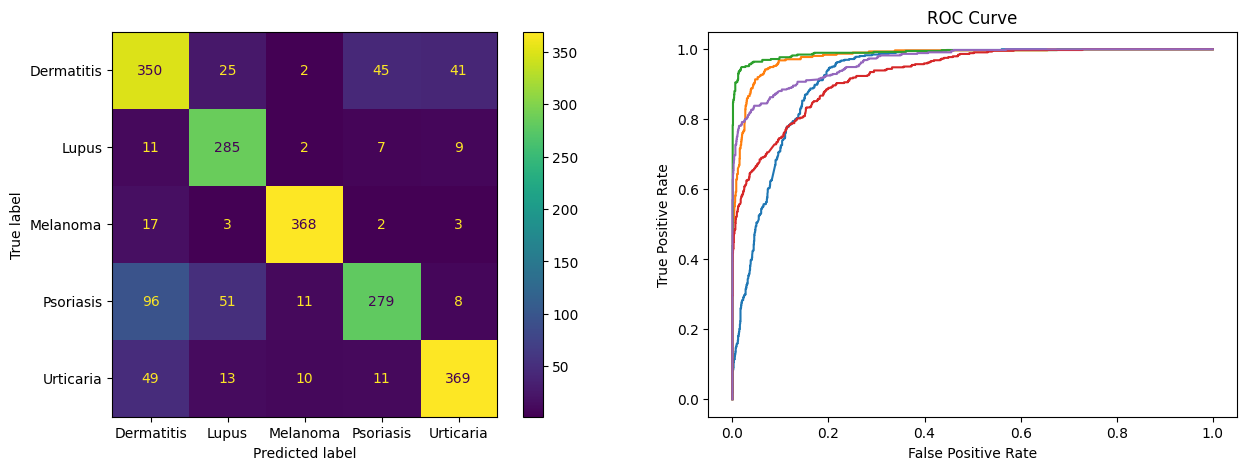

In [48]:
best_params = random_search_nb(X_train_bow_lem)
model_nb(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**BoW n-grams**

Best hyperparameters: {'alpha': 0.10604597478075117, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.8690
Specificity Score: 0.8690
Precision Score: 0.8693
F1 Score: 0.8682

Testing Results
Accuracy Score: 0.8021
Specificity Score: 0.8021
Precision Score: 0.8016
F1 Score: 0.8007

Loss
Log loss: 0.7192285190422543

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.78      0.80      0.79      1803
       Lupus       0.91      0.92      0.92      1355
    Melanoma       0.95      0.98      0.96      1677
   Psoriasis       0.87      0.76      0.81      1668
   Urticaria       0.85      0.90      0.87      1764

    accuracy                           0.87      8267
   macro avg       0.87      0.87      0.87      8267
weighted avg       0.87      0.87      0.87      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.69      0.70      0.69       463
   

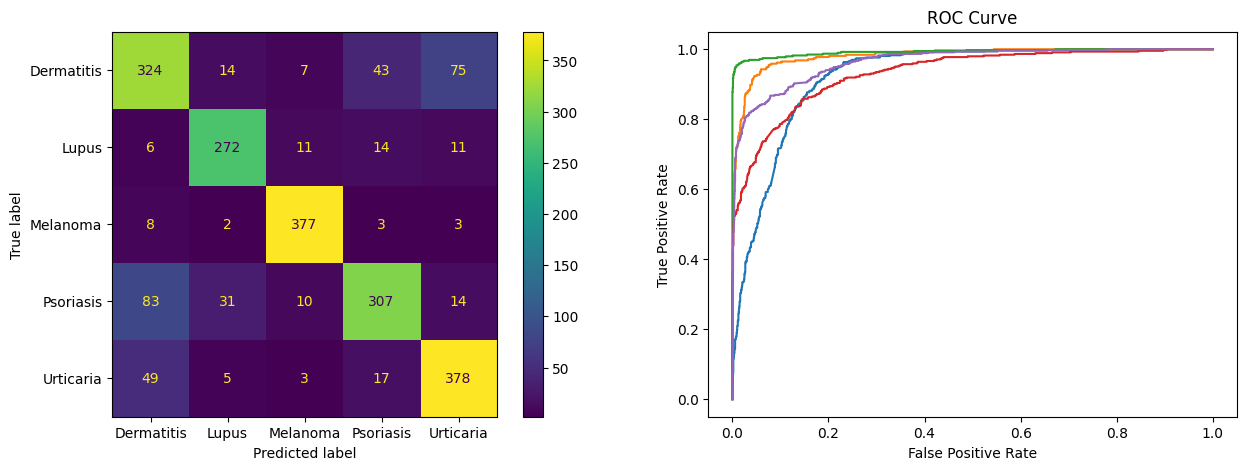

In [49]:
best_params = random_search_nb(X_train_ngram_lem)
model_nb(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

Best hyperparameters: {'alpha': 1.0045350449766937, 'fit_prior': False, 'class_prior': None}
Training Results
Accuracy Score: 0.8173
Specificity Score: 0.8173
Precision Score: 0.8151
F1 Score: 0.8139

Testing Results
Accuracy Score: 0.7808
Specificity Score: 0.7808
Precision Score: 0.7787
F1 Score: 0.7770

Loss
Log loss: 0.615491974896903

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.76      0.69      0.72      1803
       Lupus       0.85      0.88      0.87      1355
    Melanoma       0.90      0.97      0.93      1677
   Psoriasis       0.80      0.68      0.73      1668
   Urticaria       0.78      0.88      0.83      1764

    accuracy                           0.82      8267
   macro avg       0.82      0.82      0.82      8267
weighted avg       0.82      0.82      0.81      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.69      0.65      0.67       463
    

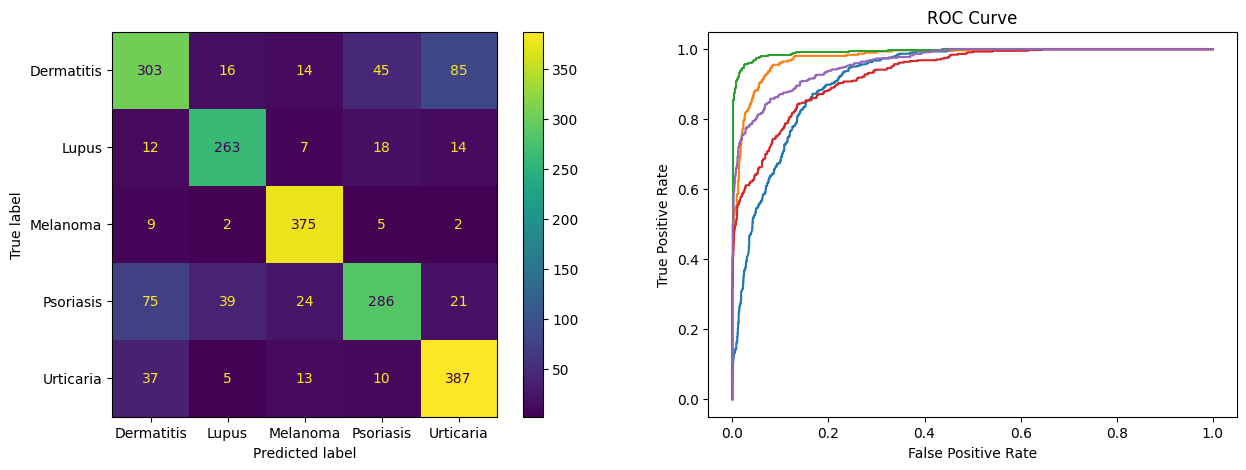

In [50]:
best_params = random_search_nb(X_train_tfidf_lem)
model_nb(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'alpha': 1.4058041156867522, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.8613
Specificity Score: 0.8613
Precision Score: 0.8646
F1 Score: 0.8613

Testing Results
Accuracy Score: 0.8079
Specificity Score: 0.8079
Precision Score: 0.8121
F1 Score: 0.8073

Loss
Log loss: 0.6121269945157776

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.77      0.81      0.79      1803
       Lupus       0.95      0.86      0.90      1355
    Melanoma       0.96      0.97      0.97      1677
   Psoriasis       0.87      0.76      0.81      1668
   Urticaria       0.81      0.90      0.85      1764

    accuracy                           0.86      8267
   macro avg       0.87      0.86      0.86      8267
weighted avg       0.86      0.86      0.86      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.70      0.73      0.71       463
    

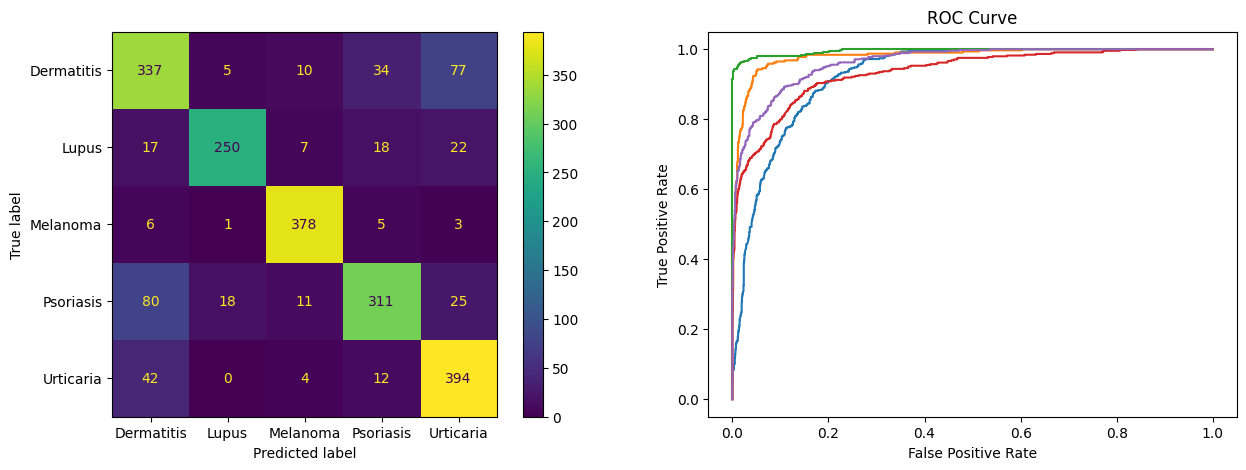

In [51]:
best_params = random_search_nb(X_train_tfidf_ngram_lem)
model_nb(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

##### Witth stemming

In [52]:
name = "NB_stem_"

**BoW** 

Best hyperparameters: {'alpha': 0.3915768055076294, 'fit_prior': True, 'class_prior': array([0.40007782, 0.10827058, 0.09226798, 0.35436861, 0.04501501])}
Training Results
Accuracy Score: 0.8648
Specificity Score: 0.8648
Precision Score: 0.8719
F1 Score: 0.8662

Testing Results
Accuracy Score: 0.8350
Specificity Score: 0.8350
Precision Score: 0.8432
F1 Score: 0.8370

Loss
Log loss: 0.5036595818626867

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.74      0.86      0.79      1803
       Lupus       0.92      0.93      0.93      1355
    Melanoma       0.98      0.96      0.97      1677
   Psoriasis       0.80      0.79      0.80      1668
   Urticaria       0.94      0.81      0.87      1764

    accuracy                           0.86      8267
   macro avg       0.88      0.87      0.87      8267
weighted avg       0.87      0.86      0.87      8267


Classification Report Test
              precision    recall  f1-score   supp

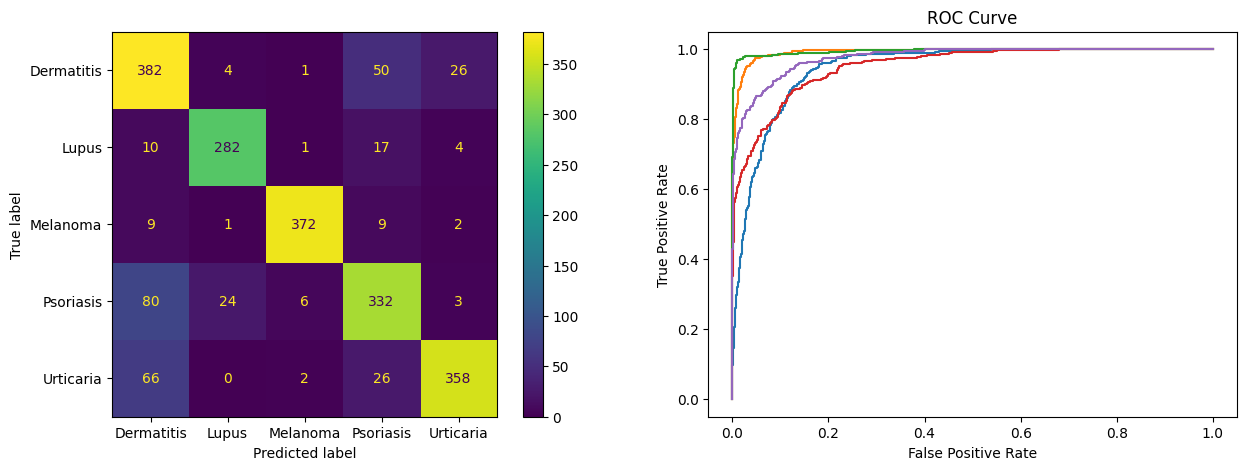

In [53]:
best_params = random_search_nb(X_train_bow_stem)
model_nb(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**BoW n-grams**

Best hyperparameters: {'alpha': 0.15425048904127503, 'fit_prior': False, 'class_prior': array([0.2324646 , 0.14370749, 0.52203058, 0.03892938, 0.06286795])}
Training Results
Accuracy Score: 0.9763
Specificity Score: 0.9763
Precision Score: 0.9766
F1 Score: 0.9762

Testing Results
Accuracy Score: 0.8626
Specificity Score: 0.8626
Precision Score: 0.8655
F1 Score: 0.8620

Loss
Log loss: 1.0932068186975425

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.95      0.97      0.96      1803
       Lupus       0.98      1.00      0.99      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       0.99      0.93      0.96      1668
   Urticaria       0.97      0.98      0.98      1764

    accuracy                           0.98      8267
   macro avg       0.98      0.98      0.98      8267
weighted avg       0.98      0.98      0.98      8267


Classification Report Test
              precision    recall  f1-score   su

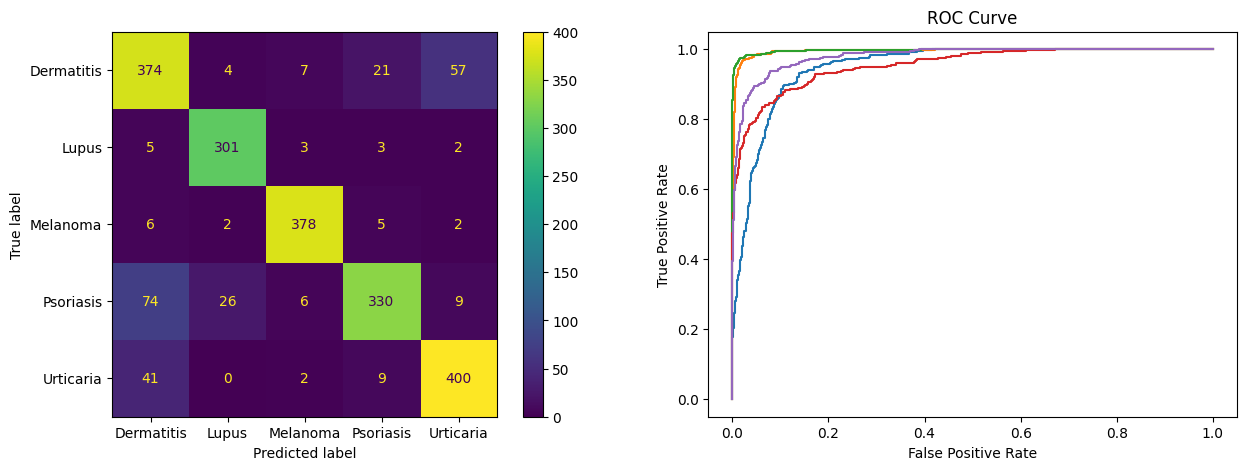

In [54]:
best_params = random_search_nb(X_train_ngram_stem)
model_nb(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

Best hyperparameters: {'alpha': 1.7647562268338013, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.8479
Specificity Score: 0.8479
Precision Score: 0.8489
F1 Score: 0.8458

Testing Results
Accuracy Score: 0.8186
Specificity Score: 0.8186
Precision Score: 0.8199
F1 Score: 0.8158

Loss
Log loss: 0.5934976551749357

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.81      0.70      0.75      1803
       Lupus       0.91      0.91      0.91      1355
    Melanoma       0.93      0.97      0.95      1677
   Psoriasis       0.84      0.76      0.80      1668
   Urticaria       0.77      0.91      0.84      1764

    accuracy                           0.85      8267
   macro avg       0.85      0.85      0.85      8267
weighted avg       0.85      0.85      0.85      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.76      0.65      0.70       463
    

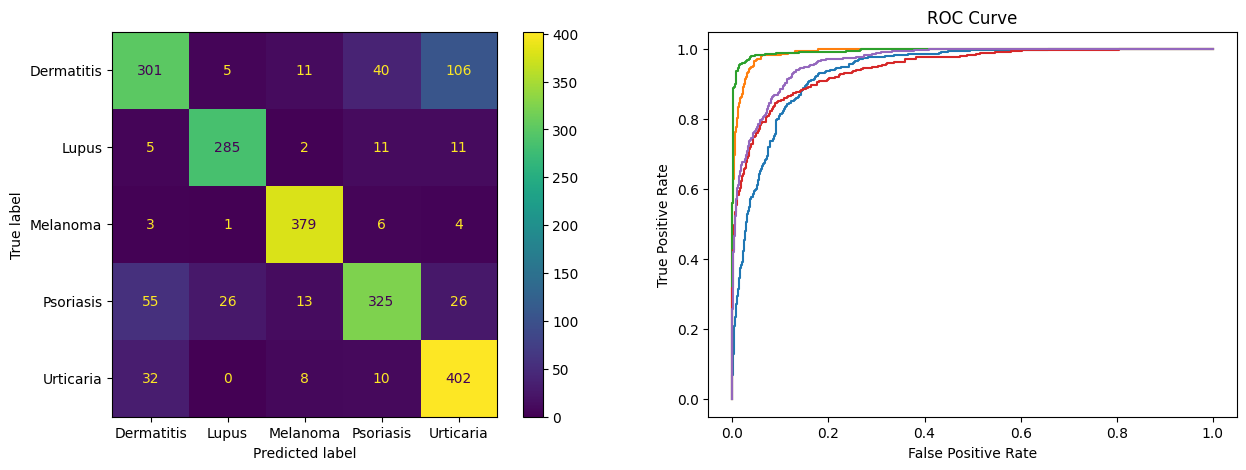

In [55]:
best_params = random_search_nb(X_train_tfidf_stem)
model_nb(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'alpha': 0.5553767041912949, 'fit_prior': True, 'class_prior': None}
Training Results
Accuracy Score: 0.9613
Specificity Score: 0.9613
Precision Score: 0.9619
F1 Score: 0.9612

Testing Results
Accuracy Score: 0.8592
Specificity Score: 0.8592
Precision Score: 0.8613
F1 Score: 0.8585

Loss
Log loss: 0.5147580582252423

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.94      0.94      0.94      1803
       Lupus       0.98      0.99      0.98      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.98      0.91      0.94      1668
   Urticaria       0.93      0.98      0.95      1764

    accuracy                           0.96      8267
   macro avg       0.96      0.96      0.96      8267
weighted avg       0.96      0.96      0.96      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.78      0.76      0.77       463
    

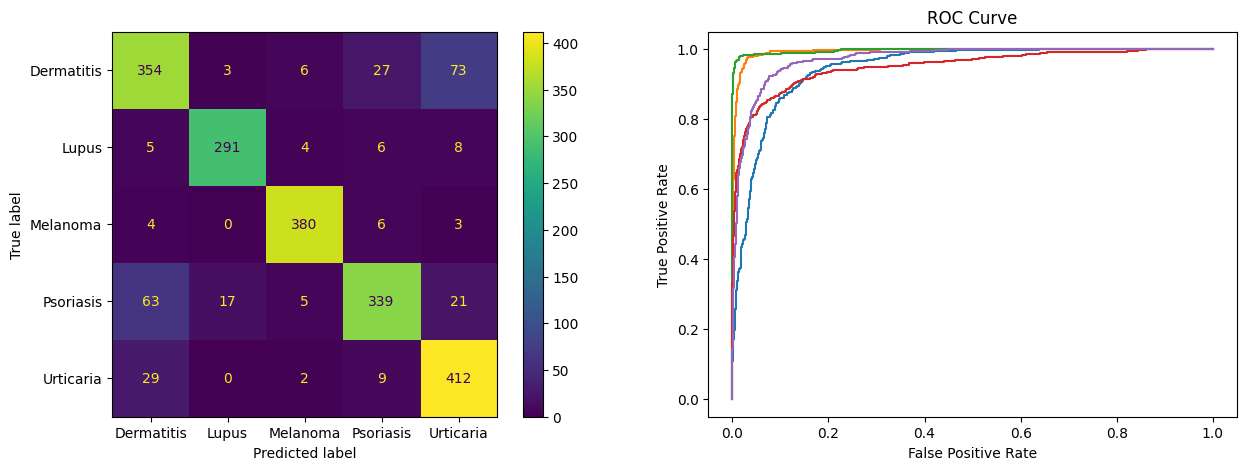

In [56]:
best_params = random_search_nb(X_train_tfidf_ngram_stem)
model_nb(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

##### Save best model

In [57]:
joblib.dump(best_model,f'Models/NB/{best_modeltype_nb}.pkl')
print(best_score_nb)

0.8620219174436214


#### Support Vector Machinne

**Important Parameters:**
- Kernel
- Gamma
- C

In [58]:
best_score_svm = 0
best_modeltype_svm = ""
best_model = None

In [59]:
def train_and_evaluate(params, X_train, y_train):
    clf = SVC(**params)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

##### Random Search #####

In [60]:
def random_search_svm(X_train):
    param_grid = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear']
    }
    
    best_score = float('-inf')
    best_params = None
    
    def evaluate_params(params):
        score = train_and_evaluate(params, X_train, y_train)
        return score

    num_iterations = 50
    num_jobs = 4  # Número de trabalhos em paralelo
    results = Parallel(n_jobs=num_jobs)(delayed(evaluate_params)({k: np.random.choice(v) for k, v in param_grid.items()}) for _ in range(num_iterations))
    
    best_index = np.argmax(results)
    best_params = {k: np.random.choice(v) for k, v in param_grid.items()}
    best_score = results[best_index]
    
    print("Best hyperparameters:", best_params)
    return best_params

##### Run Model

In [61]:
def model_svm(best_param, X_train, X_test, model_type):

    global best_score_svm, best_modeltype_svm, best_model

    svm = SVC(probability=True,C=best_param['C'], gamma = best_param['gamma'], kernel=best_param['kernel'])
    svm.fit(X_train, y_train)
    score = evaluate(svm, X_train, X_test, y_train, y_test)
    if score > best_score_svm:
        best_score_svm = score
        best_modeltype_svm = model_type
        best_model = svm

##### Without Preprocessing

In [62]:
name = "SVM_withoutyproc_"

**BoW** 

Best hyperparameters: {'C': 1000.0, 'gamma': 0.0001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.7390
Specificity Score: 0.7390
Precision Score: 0.7582
F1 Score: 0.7380

Testing Results
Accuracy Score: 0.6976
Specificity Score: 0.6976
Precision Score: 0.7165
F1 Score: 0.6959

Loss
Log loss: 0.7190441601863627

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.58      0.69      0.63      1803
       Lupus       0.86      0.84      0.85      1355
    Melanoma       0.99      0.98      0.99      1677
   Psoriasis       0.81      0.48      0.60      1668
   Urticaria       0.60      0.72      0.65      1764

    accuracy                           0.74      8267
   macro avg       0.77      0.74      0.74      8267
weighted avg       0.76      0.74      0.74      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.54      0.66      0.59       463
       Lupus       0.82   

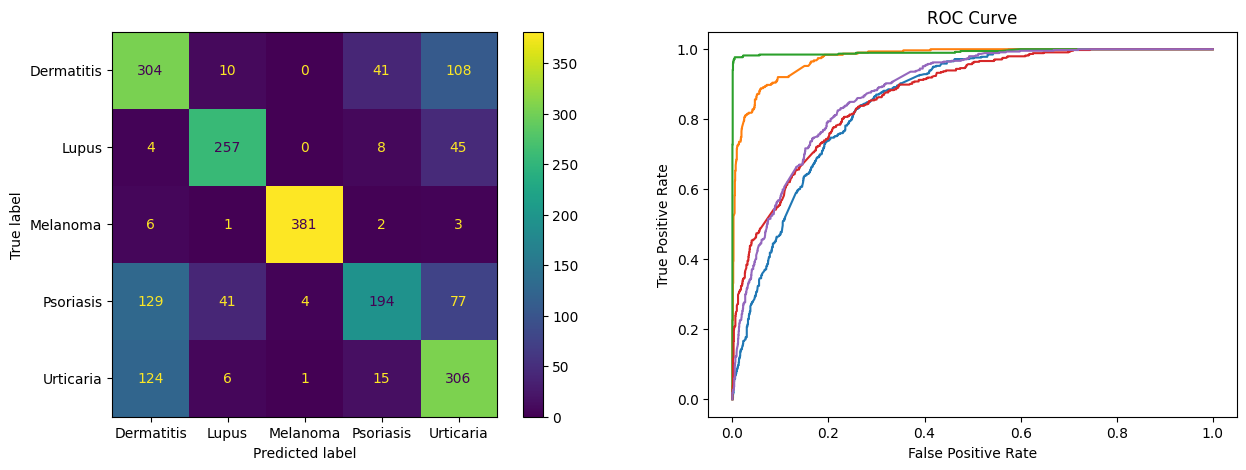

In [63]:
best_params = random_search_svm(X_train_bow_noproc)
model_svm(best_params, X_train_bow_noproc, X_test_bow_noproc , name + "bow")

**BoW n-grams**

Best hyperparameters: {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.7640
Specificity Score: 0.7640
Precision Score: 0.7855
F1 Score: 0.7636

Testing Results
Accuracy Score: 0.7107
Specificity Score: 0.7107
Precision Score: 0.7322
F1 Score: 0.7085

Loss
Log loss: 0.7083265079906299

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.62      0.71      0.66      1803
       Lupus       0.88      0.86      0.87      1355
    Melanoma       1.00      0.98      0.99      1677
   Psoriasis       0.86      0.52      0.64      1668
   Urticaria       0.61      0.77      0.68      1764

    accuracy                           0.76      8267
   macro avg       0.79      0.77      0.77      8267
weighted avg       0.79      0.76      0.76      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.56      0.67      0.61       463
       Lupus       0.84      0

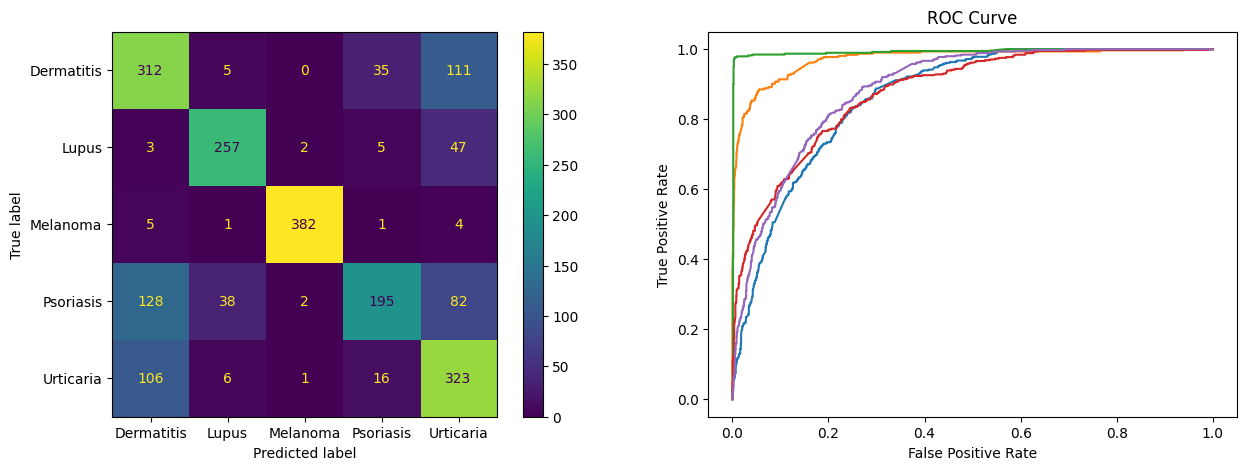

In [64]:
best_params = random_search_svm(X_train_ngram_noproc)
model_svm(best_params, X_train_ngram_noproc, X_test_ngram_noproc, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 100.0, 'gamma': 0.001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.8628
Specificity Score: 0.8628
Precision Score: 0.8662
F1 Score: 0.8629

Testing Results
Accuracy Score: 0.7644
Specificity Score: 0.7644
Precision Score: 0.7724
F1 Score: 0.7654

Loss
Log loss: 0.5999120678706503

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.73      0.83      0.78      1803
       Lupus       0.93      0.93      0.93      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       0.85      0.73      0.78      1668
   Urticaria       0.84      0.84      0.84      1764

    accuracy                           0.86      8267
   macro avg       0.87      0.87      0.87      8267
weighted avg       0.87      0.86      0.86      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.60      0.75      0.67       463
       Lupus       0.85  

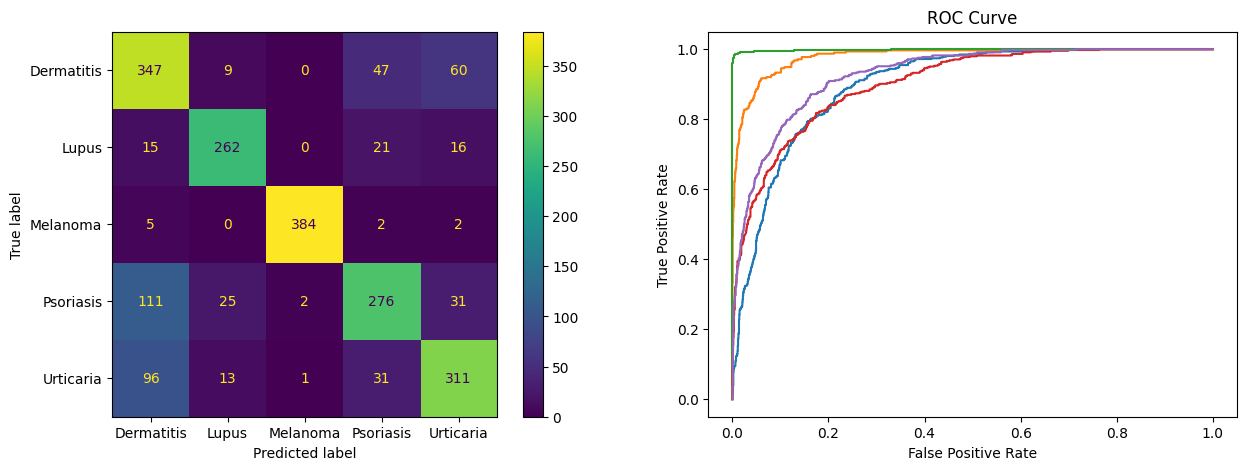

In [65]:
best_params = random_search_svm(X_train_tfidf_noproc)
model_svm(best_params, X_train_tfidf_noproc, X_test_tfidf_noproc, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.2191
Specificity Score: 0.2191
Precision Score: 0.2036
F1 Score: 0.0805

Testing Results
Accuracy Score: 0.2264
Specificity Score: 0.2264
Precision Score: 0.2404
F1 Score: 0.0869

Loss
Log loss: 1.2279285936879005

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.36      1803
       Lupus       0.00      0.00      0.00      1355
    Melanoma       0.77      0.01      0.01      1677
   Psoriasis       0.00      0.00      0.00      1668
   Urticaria       0.00      0.00      0.00      1764

    accuracy                           0.22      8267
   macro avg       0.20      0.20      0.07      8267
weighted avg       0.20      0.22      0.08      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.37       463
       Lupus       0.00      0.

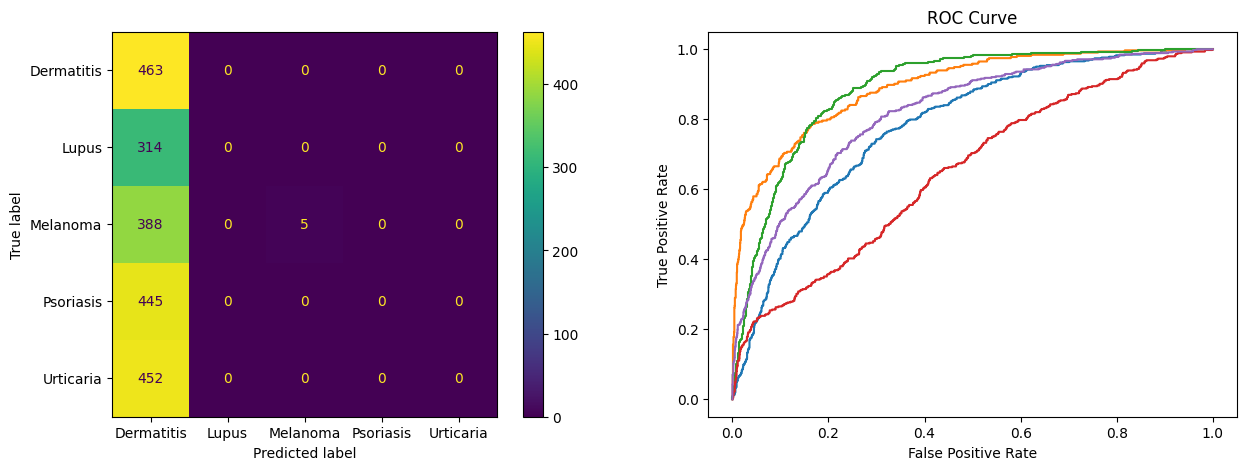

In [66]:
best_params = random_search_svm(X_train_tfidf_ngram_noproc)
model_svm(best_params, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, name + "tfidf_ngram")

##### With Preprocessing

In [67]:
name = "SVM_withproc_"

**BoW** 

Best hyperparameters: {'C': 1000.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.8850
Specificity Score: 0.8850
Precision Score: 0.8865
F1 Score: 0.8853

Testing Results
Accuracy Score: 0.6942
Specificity Score: 0.6942
Precision Score: 0.7012
F1 Score: 0.6959

Loss
Log loss: 0.858353105279769

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.79      0.86      0.82      1803
       Lupus       0.96      0.94      0.95      1355
    Melanoma       1.00      0.99      1.00      1677
   Psoriasis       0.83      0.80      0.81      1668
   Urticaria       0.88      0.85      0.86      1764

    accuracy                           0.88      8267
   macro avg       0.89      0.89      0.89      8267
weighted avg       0.89      0.88      0.89      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.58      0.63      0.60       463
       Lupus       0.79      0

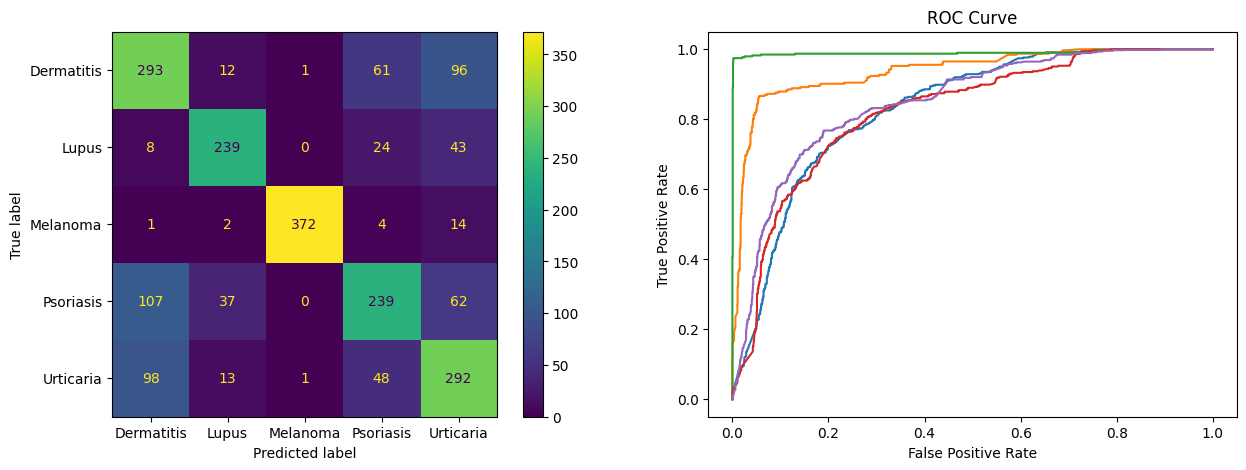

In [68]:
best_params = random_search_svm(X_train_bow_proc)
model_svm(best_params, X_train_bow_proc, X_test_bow_proc, name + "bow")

**BoW n-grams**

Best hyperparameters: {'C': 1000.0, 'gamma': 0.1, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.8360
Specificity Score: 0.8360
Precision Score: 0.8416
F1 Score: 0.8362

Testing Results
Accuracy Score: 0.6942
Specificity Score: 0.6942
Precision Score: 0.7057
F1 Score: 0.6951

Loss
Log loss: 0.7338307166918759

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.69      0.81      0.74      1803
       Lupus       0.92      0.92      0.92      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.82      0.68      0.74      1668
   Urticaria       0.81      0.81      0.81      1764

    accuracy                           0.84      8267
   macro avg       0.85      0.84      0.84      8267
weighted avg       0.84      0.84      0.84      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.51      0.66      0.57       463
       Lupus       0.77   

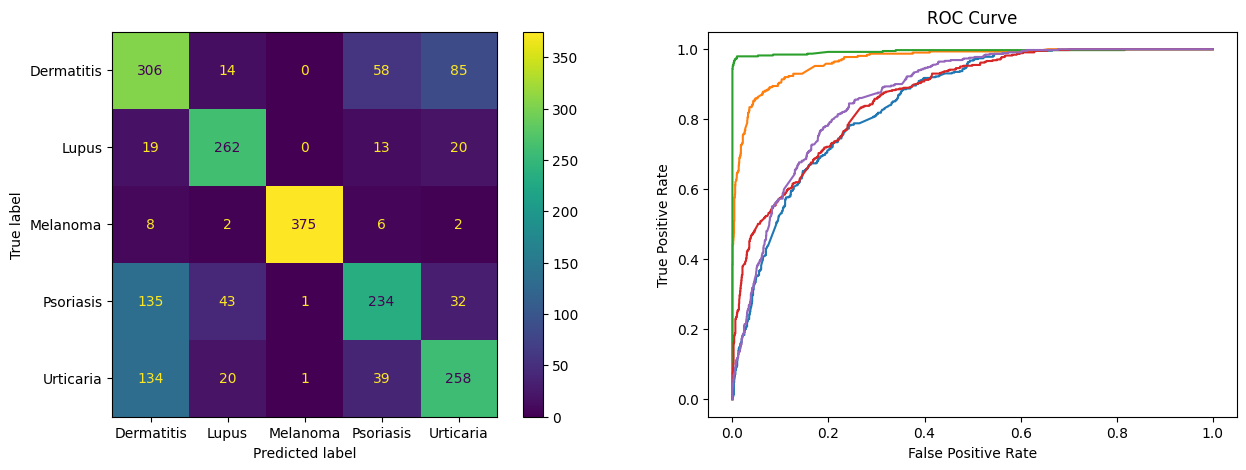

In [69]:
best_params = random_search_svm(X_train_ngram_proc)
model_svm(best_params, X_train_ngram_proc, X_test_ngram_proc, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 100.0, 'gamma': 0.001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.8194
Specificity Score: 0.8194
Precision Score: 0.8207
F1 Score: 0.8192

Testing Results
Accuracy Score: 0.7131
Specificity Score: 0.7131
Precision Score: 0.7139
F1 Score: 0.7131

Loss
Log loss: 0.6918789053958677

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.70      0.73      0.72      1803
       Lupus       0.90      0.91      0.91      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.79      0.69      0.74      1668
   Urticaria       0.75      0.79      0.77      1764

    accuracy                           0.82      8267
   macro avg       0.83      0.82      0.82      8267
weighted avg       0.82      0.82      0.82      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.58      0.62      0.60       463
       Lupus       0.80  

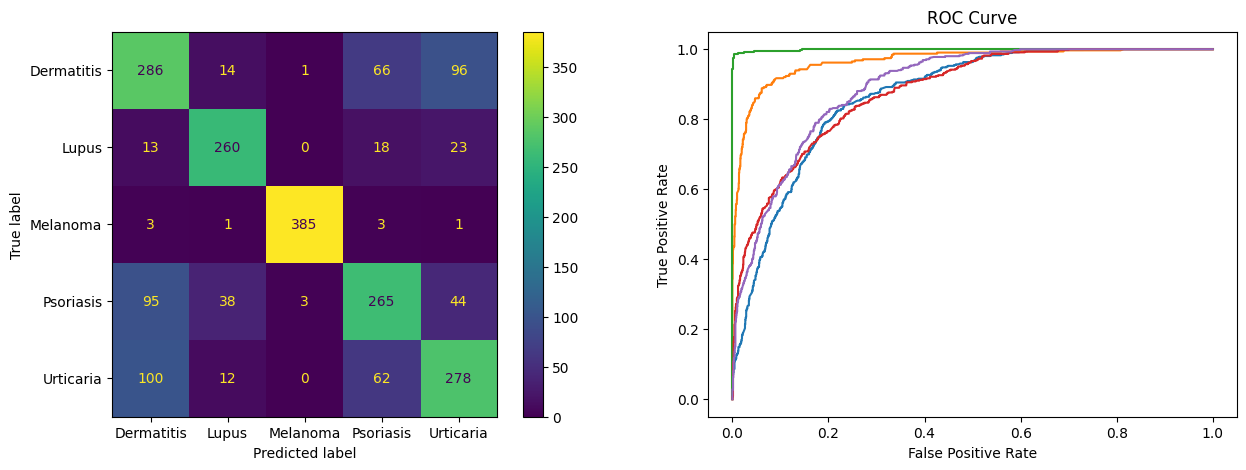

In [70]:
best_params = random_search_svm(X_train_tfidf_proc)
model_svm(best_params, X_train_tfidf_proc, X_test_tfidf_proc, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.8407
Specificity Score: 0.8407
Precision Score: 0.8451
F1 Score: 0.8410

Testing Results
Accuracy Score: 0.7412
Specificity Score: 0.7412
Precision Score: 0.7483
F1 Score: 0.7425

Loss
Log loss: 0.6524126919786686

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.75      0.76      0.76      1803
       Lupus       0.93      0.90      0.91      1355
    Melanoma       1.00      0.99      0.99      1677
   Psoriasis       0.84      0.72      0.77      1668
   Urticaria       0.74      0.85      0.79      1764

    accuracy                           0.84      8267
   macro avg       0.85      0.84      0.85      8267
weighted avg       0.85      0.84      0.84      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.60      0.62      0.61       463
       Lupus       0.87   

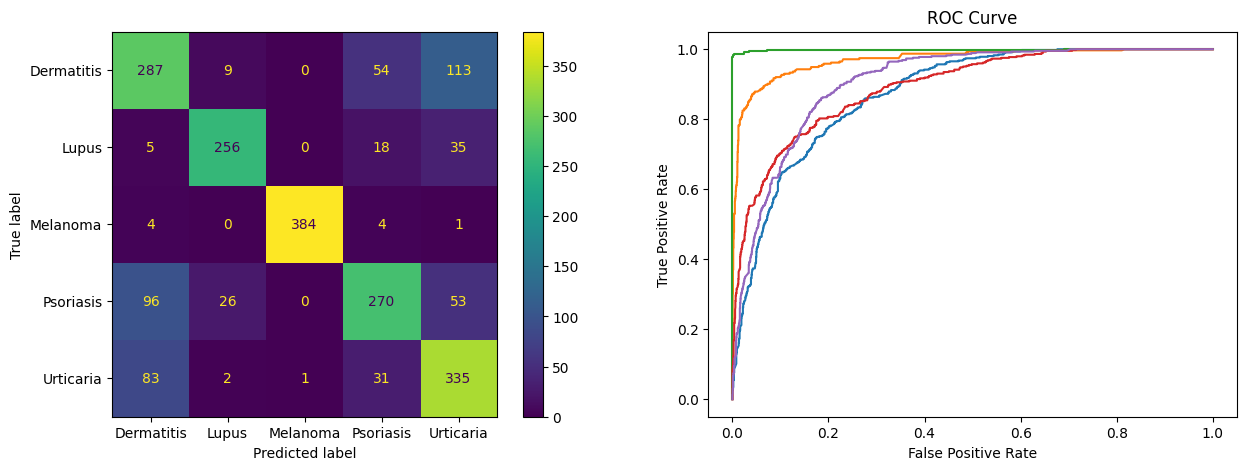

In [71]:
best_params = random_search_svm(X_train_tfidf_ngram_proc)
model_svm(best_params, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, name + "tfidf_ngram")

##### With lamatization

In [72]:
name = "SVM_lem_"

**BoW** 

Best hyperparameters: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.2181
Specificity Score: 0.2181
Precision Score: 0.0476
F1 Score: 0.0781

Testing Results
Accuracy Score: 0.2240
Specificity Score: 0.2240
Precision Score: 0.0502
F1 Score: 0.0820

Loss
Log loss: 1.0622423606563065

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.36      1803
       Lupus       0.00      0.00      0.00      1355
    Melanoma       0.00      0.00      0.00      1677
   Psoriasis       0.00      0.00      0.00      1668
   Urticaria       0.00      0.00      0.00      1764

    accuracy                           0.22      8267
   macro avg       0.04      0.20      0.07      8267
weighted avg       0.05      0.22      0.08      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.37       463
       Lupus       0.00      

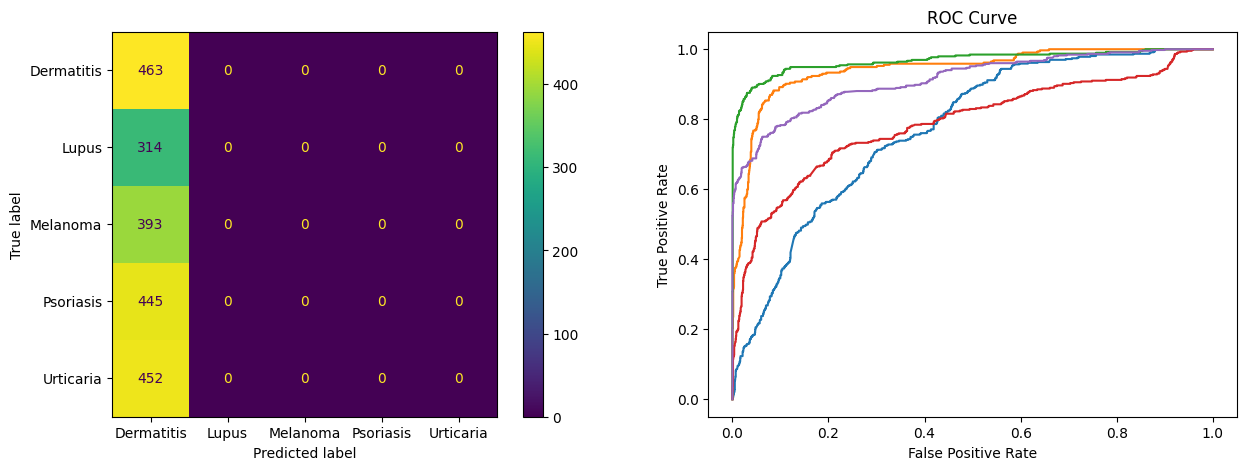

In [73]:
best_params = random_search_svm(X_train_bow_lem)
model_svm(best_params, X_train_bow_lem, X_test_bow_lem, name + "bow")

**BoW n-grams**

Best hyperparameters: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.2181
Specificity Score: 0.2181
Precision Score: 0.0476
F1 Score: 0.0781

Testing Results
Accuracy Score: 0.2240
Specificity Score: 0.2240
Precision Score: 0.0502
F1 Score: 0.0820

Loss
Log loss: 1.0435183660731786

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.36      1803
       Lupus       0.00      0.00      0.00      1355
    Melanoma       0.00      0.00      0.00      1677
   Psoriasis       0.00      0.00      0.00      1668
   Urticaria       0.00      0.00      0.00      1764

    accuracy                           0.22      8267
   macro avg       0.04      0.20      0.07      8267
weighted avg       0.05      0.22      0.08      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.37       463
       Lupus       0.00      

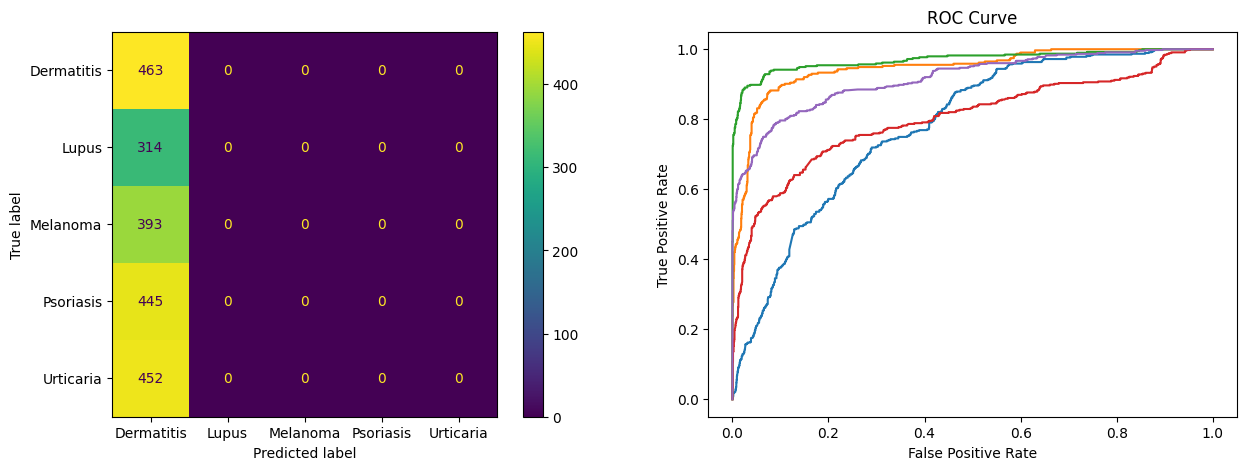

In [74]:
best_params = random_search_svm(X_train_ngram_lem)
model_svm(best_params, X_train_ngram_lem, X_test_ngram_lem, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.8114
Specificity Score: 0.8114
Precision Score: 0.8459
F1 Score: 0.8146

Testing Results
Accuracy Score: 0.8021
Specificity Score: 0.8021
Precision Score: 0.8369
F1 Score: 0.8050

Loss
Log loss: 0.49379208644441225

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.60      0.91      0.73      1803
       Lupus       0.86      0.88      0.87      1355
    Melanoma       0.98      0.93      0.96      1677
   Psoriasis       0.82      0.61      0.70      1668
   Urticaria       0.98      0.73      0.83      1764

    accuracy                           0.81      8267
   macro avg       0.85      0.81      0.82      8267
weighted avg       0.85      0.81      0.81      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.60      0.89      0.72       463
       Lupus       0.84  

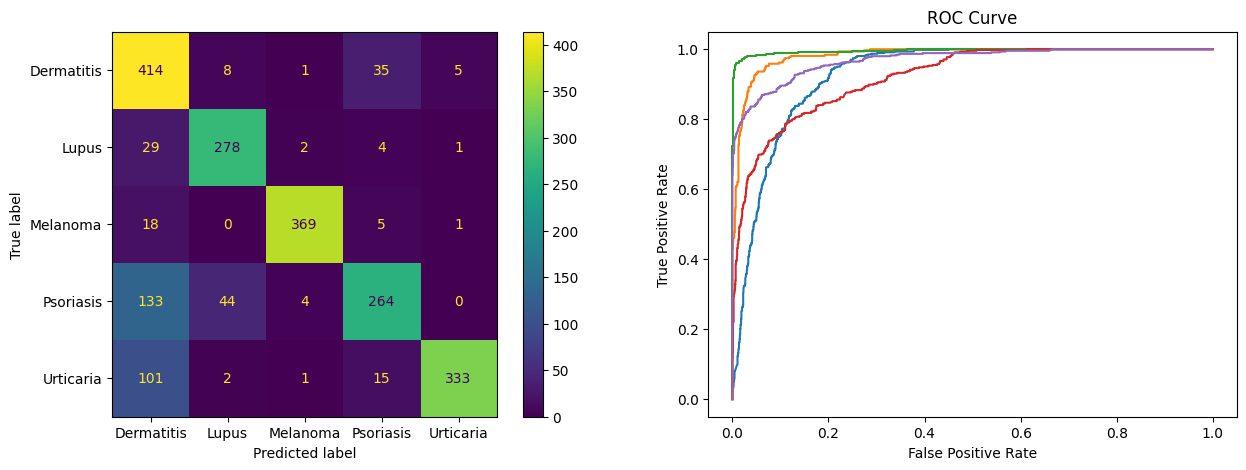

In [75]:
best_params = random_search_svm(X_train_tfidf_lem)
model_svm(best_params, X_train_tfidf_lem, X_test_tfidf_lem, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
Training Results
Accuracy Score: 0.9139
Specificity Score: 0.9139
Precision Score: 0.9197
F1 Score: 0.9148

Testing Results
Accuracy Score: 0.8399
Specificity Score: 0.8399
Precision Score: 0.8526
F1 Score: 0.8422

Loss
Log loss: 0.43327985531627977

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.79      0.93      0.85      1803
       Lupus       0.96      0.96      0.96      1355
    Melanoma       0.99      0.98      0.98      1677
   Psoriasis       0.91      0.84      0.87      1668
   Urticaria       0.96      0.88      0.92      1764

    accuracy                           0.91      8267
   macro avg       0.92      0.92      0.92      8267
weighted avg       0.92      0.91      0.91      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.67      0.85      0.75       463
       Lupus       0.90  

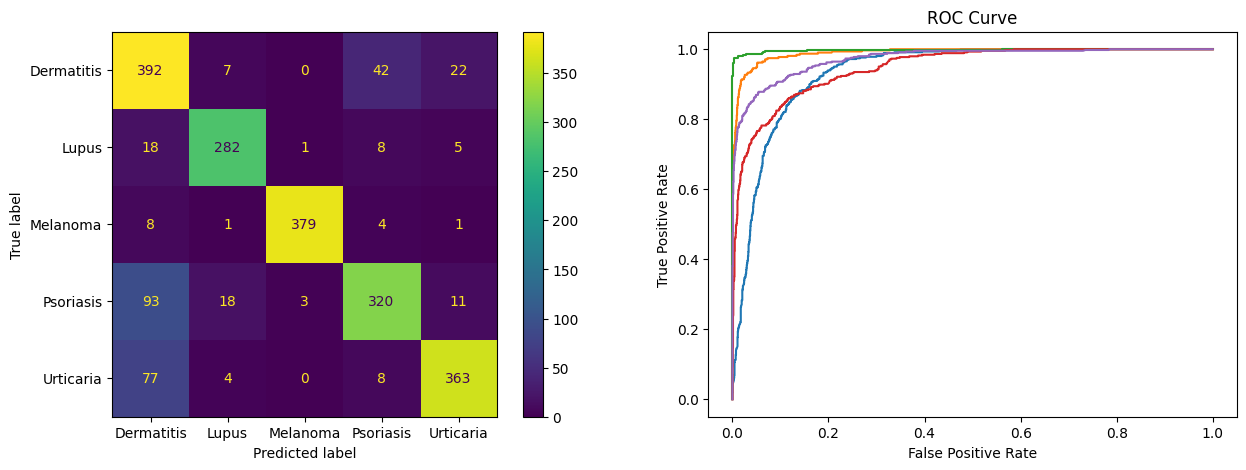

In [76]:
best_params = random_search_svm(X_train_tfidf_ngram_lem)
model_svm(best_params, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, name + "tfidf_ngram")

##### Witth stemming

In [77]:
name = "SVM_stem_"

**BoW** 

Best hyperparameters: {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.9987
Specificity Score: 0.9987
Precision Score: 0.9987
F1 Score: 0.9987

Testing Results
Accuracy Score: 0.5520
Specificity Score: 0.5520
Precision Score: 0.7257
F1 Score: 0.5357

Loss
Log loss: 0.8379932891349245

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       1.00      1.00      1.00      1803
       Lupus       1.00      1.00      1.00      1355
    Melanoma       1.00      1.00      1.00      1677
   Psoriasis       1.00      1.00      1.00      1668
   Urticaria       1.00      1.00      1.00      1764

    accuracy                           1.00      8267
   macro avg       1.00      1.00      1.00      8267
weighted avg       1.00      1.00      1.00      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.52      0.76      0.61       463
       Lupus       0.95      0.2

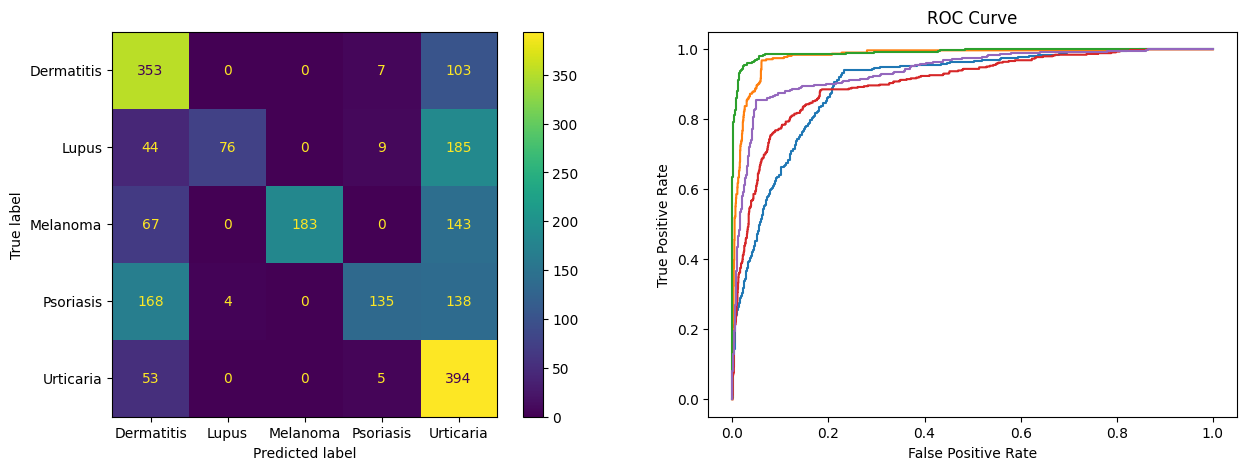

In [78]:
best_params = random_search_svm(X_train_bow_stem)
model_svm(best_params, X_train_bow_stem, X_test_bow_stem, name + "bow")

**BoW n-grams**

Best hyperparameters: {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.2181
Specificity Score: 0.2181
Precision Score: 0.0476
F1 Score: 0.0781

Testing Results
Accuracy Score: 0.2240
Specificity Score: 0.2240
Precision Score: 0.0502
F1 Score: 0.0820

Loss
Log loss: 1.544246889096158

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.36      1803
       Lupus       0.00      0.00      0.00      1355
    Melanoma       0.00      0.00      0.00      1677
   Psoriasis       0.00      0.00      0.00      1668
   Urticaria       0.00      0.00      0.00      1764

    accuracy                           0.22      8267
   macro avg       0.04      0.20      0.07      8267
weighted avg       0.05      0.22      0.08      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.22      1.00      0.37       463
       Lupus       0.00      0.00

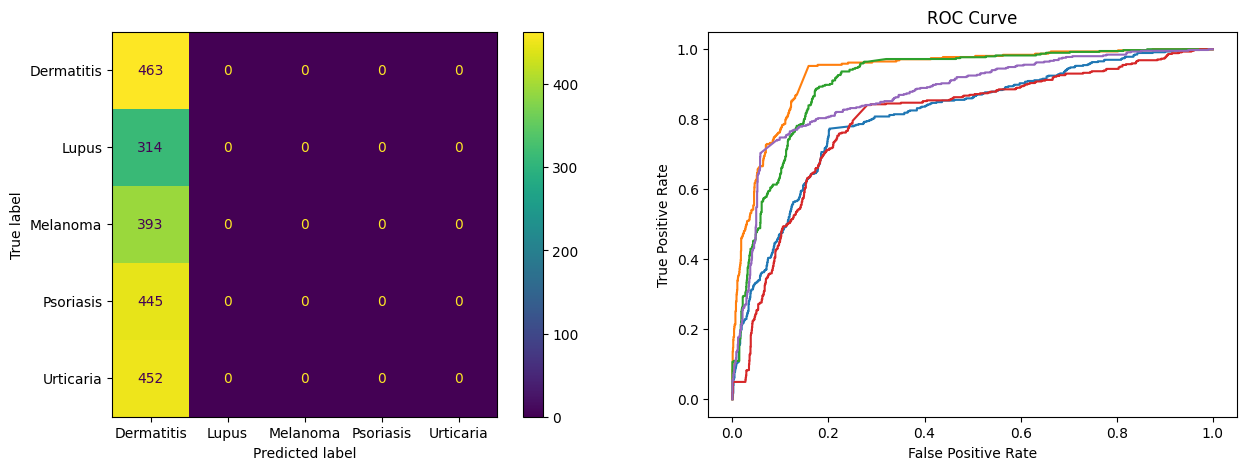

In [79]:
best_params = random_search_svm(X_train_ngram_stem)
model_svm(best_params, X_train_ngram_stem, X_test_ngram_stem, name + "ngram")

**TF-IDF**

Best hyperparameters: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.9376
Specificity Score: 0.9376
Precision Score: 0.9400
F1 Score: 0.9379

Testing Results
Accuracy Score: 0.8805
Specificity Score: 0.8805
Precision Score: 0.8852
F1 Score: 0.8811

Loss
Log loss: 0.32529040986663604

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.85      0.94      0.89      1803
       Lupus       0.97      0.98      0.98      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.93      0.87      0.90      1668
   Urticaria       0.97      0.92      0.94      1764

    accuracy                           0.94      8267
   macro avg       0.94      0.94      0.94      8267
weighted avg       0.94      0.94      0.94      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.76      0.89      0.82       463
       Lupus       0.94   

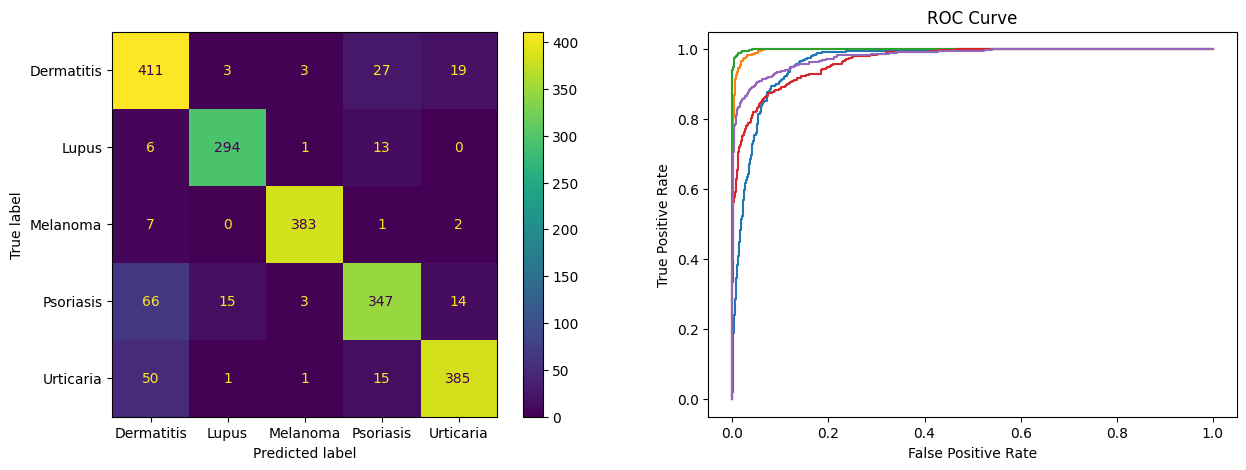

In [80]:
best_params = random_search_svm(X_train_tfidf_stem)
model_svm(best_params, X_train_tfidf_stem, X_test_tfidf_stem, name + "tfidf")

**TF-IDF n-grams**

Best hyperparameters: {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
Training Results
Accuracy Score: 0.9047
Specificity Score: 0.9047
Precision Score: 0.9198
F1 Score: 0.9070

Testing Results
Accuracy Score: 0.8505
Specificity Score: 0.8505
Precision Score: 0.8759
F1 Score: 0.8539

Loss
Log loss: 0.36739176019184555

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.74      0.96      0.83      1803
       Lupus       0.98      0.93      0.96      1355
    Melanoma       1.00      0.96      0.98      1677
   Psoriasis       0.94      0.79      0.86      1668
   Urticaria       0.97      0.87      0.92      1764

    accuracy                           0.90      8267
   macro avg       0.92      0.91      0.91      8267
weighted avg       0.92      0.90      0.91      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.66      0.94      0.77       463
       Lupus       0.95      

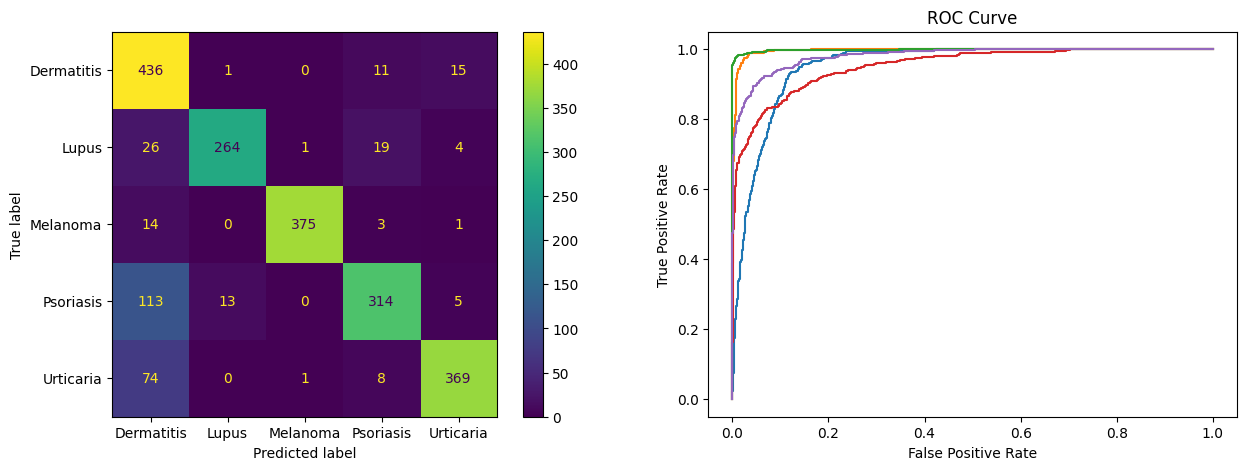

In [81]:
best_params = random_search_svm(X_train_tfidf_ngram_stem)
model_svm(best_params, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, name + "tfidf_ngram")

##### Save best model

In [82]:
joblib.dump(best_model,f'Models/SVM/{best_modeltype_svm}.pkl')
print(best_score_svm)

0.8810877399557137


### Deep Learning

In [88]:
def preprocessing_dl(vocab_size, mean_length, X_train, X_test):
    tokenizer = Tokenizer(num_words=vocab_size,oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    # Convert texts to sequences
    seq_train = tokenizer.texts_to_sequences(X_train.apply(' '.join))
    seq_test = tokenizer.texts_to_sequences(X_test.apply(' '.join))

    # Pad the sequences to the same size
    pad_train = pad_sequences(seq_train, maxlen = mean_length)
    pad_test = pad_sequences(seq_test, maxlen = mean_length)

    word_index = tokenizer.word_index
    print(len(word_index))
    return pad_train, pad_test


In [89]:
# Convert labels into numeric
diseases = {
    'Dermatitis': 0,
    'Lupus': 1,
    'Melanoma': 2,
    'Psoriasis': 3,
    'Urticaria': 4
}

# Create array with numeric diseases
train_labels = np.array(
    [diseases[label] for label in train['Disease']])
test_labels = np.array(
    [diseases[label] for label in test['Disease']])

from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


In [96]:
def analyse_data(data):
    words = set()

    for sentence in data:
        for word in sentence:
            words.add(word)

    num_unique_words = len(words)
    print(f"Number of unique words: {num_unique_words}")

    mean_length = int(data.apply(len).max())
    print(f"Max length: {mean_length}")

    return num_unique_words, mean_length

#### Recurrent Neural Network

##### Model

embedding_dimensions =  number_of_categories**0.25

https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html


In [91]:
def RNN_model(embedding_dim,vocab_size,pad_train,pad_test,proc_type):
    
    rnn = Sequential(name="Basic_RNN")
    rnn.add(Embedding(vocab_size, embedding_dim)) 
    rnn.add(SimpleRNN(128, activation='tanh', return_sequences=True))
    rnn.add(SimpleRNN(64, activation='tanh', return_sequences=False))
    rnn.add(Dense(32, activation='relu'))
    rnn.add(Dense(5, activation='softmax'))

    rnn.build(input_shape=(None, pad_train.shape[1]))

    print(rnn.summary())

    rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','f1_score'])

    history = rnn.fit(
        pad_train, 
        train_labels, 
        epochs=10,
        batch_size=16,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(rnn, history, pad_test, test_labels)
    rnn.save('Models/RNN/rnn_'+ proc_type + '.keras')

##### Without Preprocessing

In [97]:
vocab_size, max_length = analyse_data(data['User_input'])

Number of unique words: 4630
Max length: 58


4210


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)        │ (None, 58, 100)        │       463,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_52 (SimpleRNN)       │ (None, 58, 128)        │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_53 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 506,909 (1.93 MB)

 Trainable params: 506,909 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.2218 - f1_score: 0.2054 - loss: 1.6065 - val_accuracy: 0.2225 - val_f1_score: 0.1424 - val_loss: 1.5957
Epoch 2/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.3303 - f1_score: 0.3243 - loss: 1.5134 - val_accuracy: 0.4847 - val_f1_score: 0.4570 - val_loss: 1.0382
Epoch 3/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.5494 - f1_score: 0.5543 - loss: 1.0004 - val_accuracy: 0.6002 - val_f1_score: 0.5717 - val_loss: 0.9360
Epoch 4/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.6814 - f1_score: 0.6864 - loss: 0.7499 - val_accuracy: 0.6917 - val_f1_score: 0.6938 - val_loss: 0.7570
Epoch 5/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.6814 - f1_score: 0.6840 - loss: 0.7864 - val_accuracy: 0.6073 - val_f1_score: 0.6046 - val_loss: 0.9388
Epoch 6/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.6675 - f1_score: 0.6684 - loss: 0.8108 - val_accuracy: 0.7614 - val

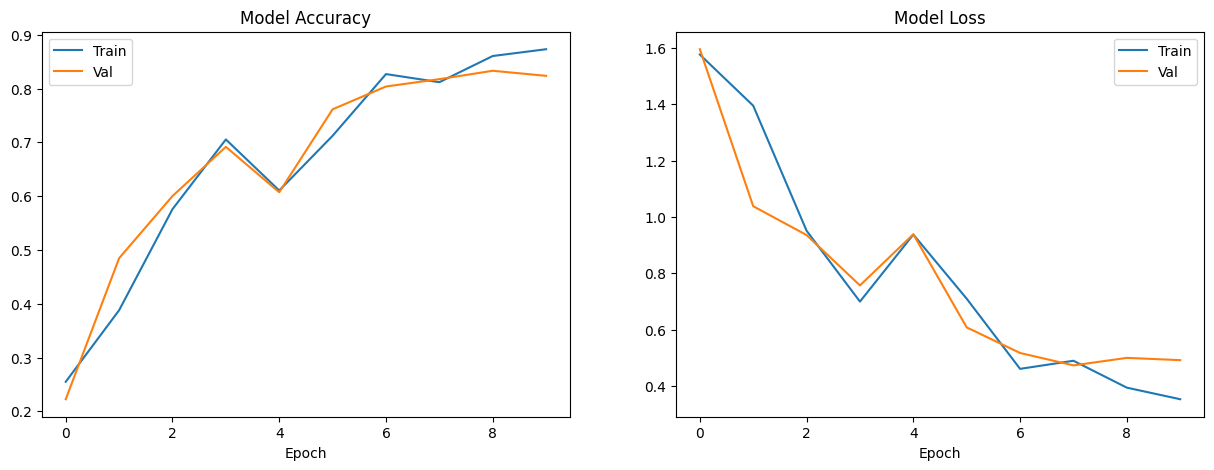

In [98]:
pad_train, pad_test = preprocessing_dl(vocab_size, max_length , train['User_input'] , test['User_input'])

RNN_model(100,vocab_size, pad_train, pad_test, 'withoutproc')

4146


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 32, 100)        │       463,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_32 (SimpleRNN)       │ (None, 32, 128)        │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_33 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507,009 (1.93 MB)

 Trainable params: 507,009 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.3170 - f1_score: 0.3125 - loss: 1.4768 - val_accuracy: 0.7789 - val_f1_score: 0.7842 - val_loss: 0.5994
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8026 - f1_score: 0.8034 - loss: 0.5372 - val_accuracy: 0.8263 - val_f1_score: 0.8342 - val_loss: 0.4932
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8246 - f1_score: 0.8252 - loss: 0.4794 - val_accuracy: 0.8278 - val_f1_score: 0.8326 - val_loss: 0.5143
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8866 - f1_score: 0.8889 - loss: 0.3134 - val_accuracy: 0.8345 - val_f1_score: 0.8442 - val_loss: 0.4877
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9467 - f1_score: 0.9480 - loss: 0.1688 - val_accuracy: 0.8549 - val_f1_score: 0.8632 - val_loss: 0.4604
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9439 - f1_score: 0.9450 - loss: 0.1728 - val_accuracy: 0.8220 - val_f1

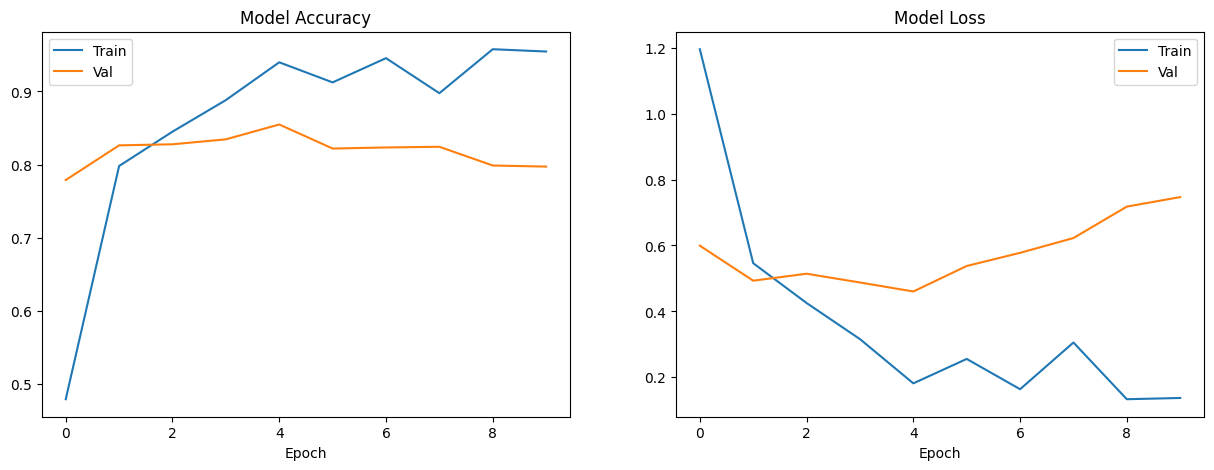

In [53]:
pad_train, pad_test = preprocessing_dl(vocab_size, 32 , train['User_input'], test['User_input'])

RNN_model(100,vocab_size, pad_train, pad_test, 'withoutproc')

4146


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 64, 100)        │       463,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_34 (SimpleRNN)       │ (None, 64, 128)        │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_35 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507,009 (1.93 MB)

 Trainable params: 507,009 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.2663 - f1_score: 0.2508 - loss: 1.5687 - val_accuracy: 0.6333 - val_f1_score: 0.6146 - val_loss: 0.8723
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.7332 - f1_score: 0.7301 - loss: 0.6687 - val_accuracy: 0.7678 - val_f1_score: 0.7791 - val_loss: 0.6246
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.7804 - f1_score: 0.7837 - loss: 0.5494 - val_accuracy: 0.7726 - val_f1_score: 0.7771 - val_loss: 0.5983
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.8100 - f1_score: 0.8112 - loss: 0.5012 - val_accuracy: 0.8166 - val_f1_score: 0.8262 - val_loss: 0.5103
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8707 - f1_score: 0.8729 - loss: 0.3907 - val_accuracy: 0.8408 - val_f1_score: 0.8491 - val_loss: 0.5041
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.8584 - f1_score: 0.8602 - loss: 0.4115 - val_accuracy: 0.8249 - val

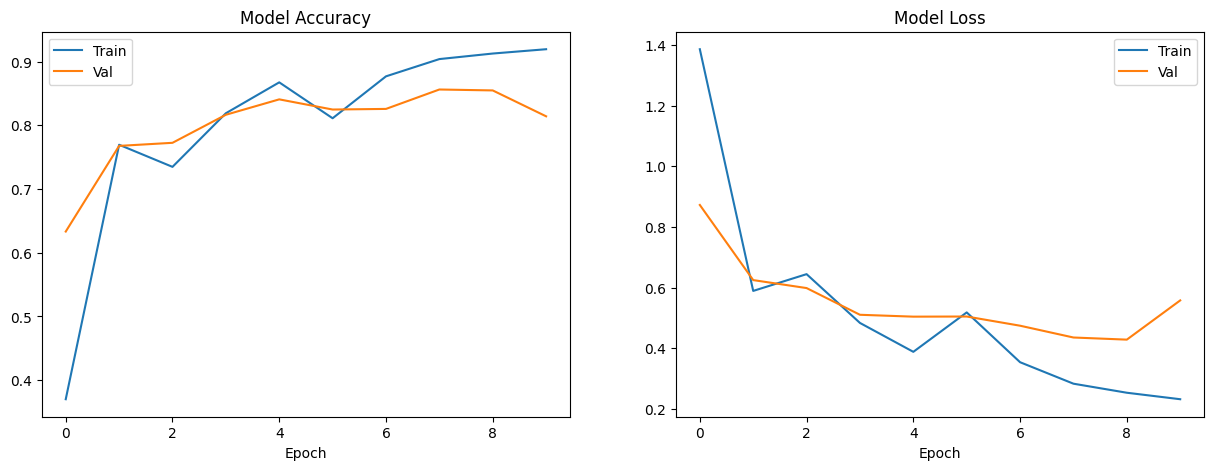

In [54]:
pad_train, pad_test = preprocessing_dl(vocab_size, 64 , train['User_input'], test['User_input'])

RNN_model(100,vocab_size, pad_train, pad_test, 'withoutproc')

4146


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 128, 100)       │       463,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_36 (SimpleRNN)       │ (None, 128, 128)       │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_37 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507,009 (1.93 MB)

 Trainable params: 507,009 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 34s 56ms/step - accuracy: 0.2038 - f1_score: 0.1817 - loss: 1.6398 - val_accuracy: 0.2390 - val_f1_score: 0.1030 - val_loss: 1.6174
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - accuracy: 0.3752 - f1_score: 0.3545 - loss: 1.4111 - val_accuracy: 0.4180 - val_f1_score: 0.4032 - val_loss: 1.3353
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 29s 55ms/step - accuracy: 0.5299 - f1_score: 0.5266 - loss: 1.0719 - val_accuracy: 0.6357 - val_f1_score: 0.6358 - val_loss: 0.8236
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.6932 - f1_score: 0.6984 - loss: 0.7228 - val_accuracy: 0.6594 - val_f1_score: 0.6653 - val_loss: 0.8201
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.7471 - f1_score: 0.7526 - loss: 0.6066 - val_accuracy: 0.6744 - val_f1_score: 0.6823 - val_loss: 0.8062
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.8100 - f1_score: 0.8168 - loss: 0.5064 - val_accuracy: 0.7881 - val

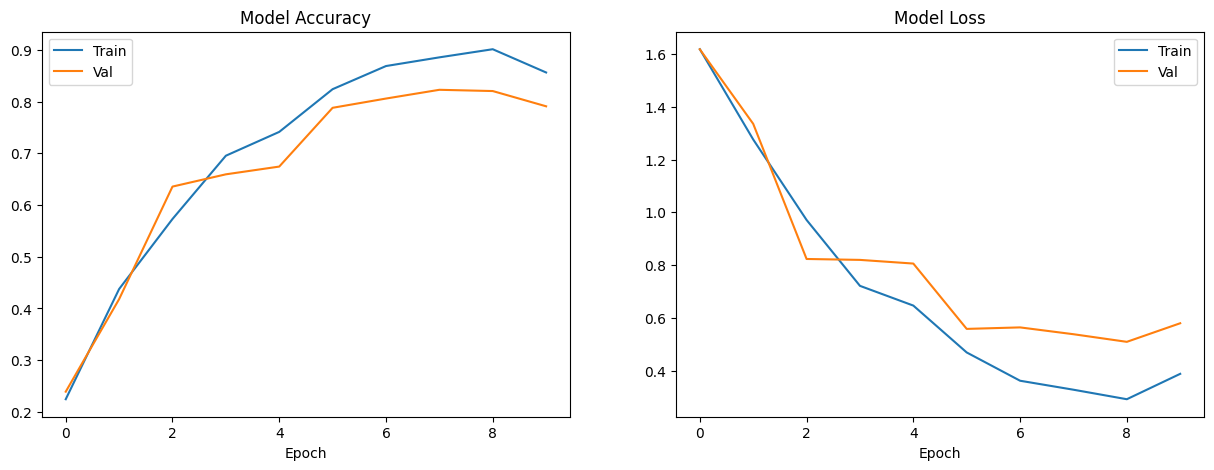

In [55]:
pad_train, pad_test = preprocessing_dl(vocab_size, 128 , train['User_input'], test['User_input'])

RNN_model(100,vocab_size, pad_train, pad_test, 'withoutproc')

4146


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 128, 200)       │       926,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_38 (SimpleRNN)       │ (None, 128, 128)       │        42,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_39 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 982,909 (3.75 MB)

 Trainable params: 982,909 (3.75 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 37s 64ms/step - accuracy: 0.2084 - f1_score: 0.1947 - loss: 1.6426 - val_accuracy: 0.2521 - val_f1_score: 0.1220 - val_loss: 1.5996
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.2615 - f1_score: 0.1903 - loss: 1.5587 - val_accuracy: 0.4611 - val_f1_score: 0.4605 - val_loss: 1.1937
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.5061 - f1_score: 0.5037 - loss: 1.0856 - val_accuracy: 0.6730 - val_f1_score: 0.6800 - val_loss: 0.7928
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.7849 - f1_score: 0.7931 - loss: 0.5538 - val_accuracy: 0.8104 - val_f1_score: 0.8181 - val_loss: 0.5178
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.8567 - f1_score: 0.8594 - loss: 0.4114 - val_accuracy: 0.8200 - val_f1_score: 0.8286 - val_loss: 0.5067
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - accuracy: 0.8624 - f1_score: 0.8665 - loss: 0.3977 - val_accuracy: 0.8428 - val

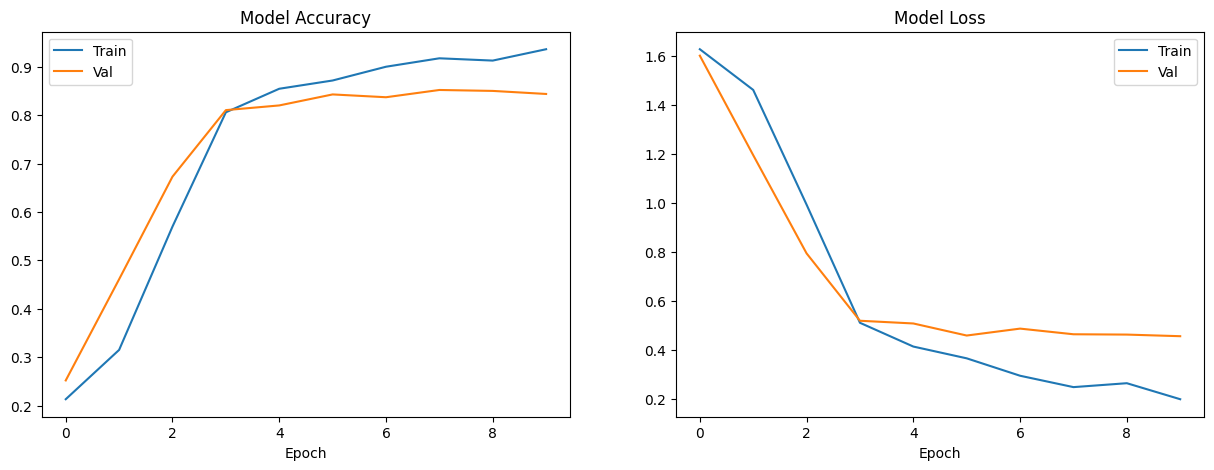

In [56]:
pad_train, pad_test = preprocessing_dl(vocab_size, 128 , train['User_input'], test['User_input'])

RNN_model(200,vocab_size, pad_train, pad_test, 'withoutproc')

##### With Preprocessing

In [99]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

Number of unique words: 4630
Max length: 58


4210


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ (None, 58, 100)        │       463,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_54 (SimpleRNN)       │ (None, 58, 128)        │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_55 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 506,909 (1.93 MB)

 Trainable params: 506,909 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.3630 - f1_score: 0.3504 - loss: 1.4041 - val_accuracy: 0.7878 - val_f1_score: 0.7910 - val_loss: 0.5487
Epoch 2/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8397 - f1_score: 0.8437 - loss: 0.4536 - val_accuracy: 0.8520 - val_f1_score: 0.8566 - val_loss: 0.4028
Epoch 3/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.9098 - f1_score: 0.9132 - loss: 0.2691 - val_accuracy: 0.8345 - val_f1_score: 0.8370 - val_loss: 0.5096
Epoch 4/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.9338 - f1_score: 0.9359 - loss: 0.1993 - val_accuracy: 0.8571 - val_f1_score: 0.8602 - val_loss: 0.4321
Epoch 5/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8748 - f1_score: 0.8771 - loss: 0.3609 - val_accuracy: 0.8307 - val_f1_score: 0.8333 - val_loss: 0.4899
Epoch 6/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.9010 - f1_score: 0.9041 - loss: 0.3039 - val_accuracy: 0.8392 - val

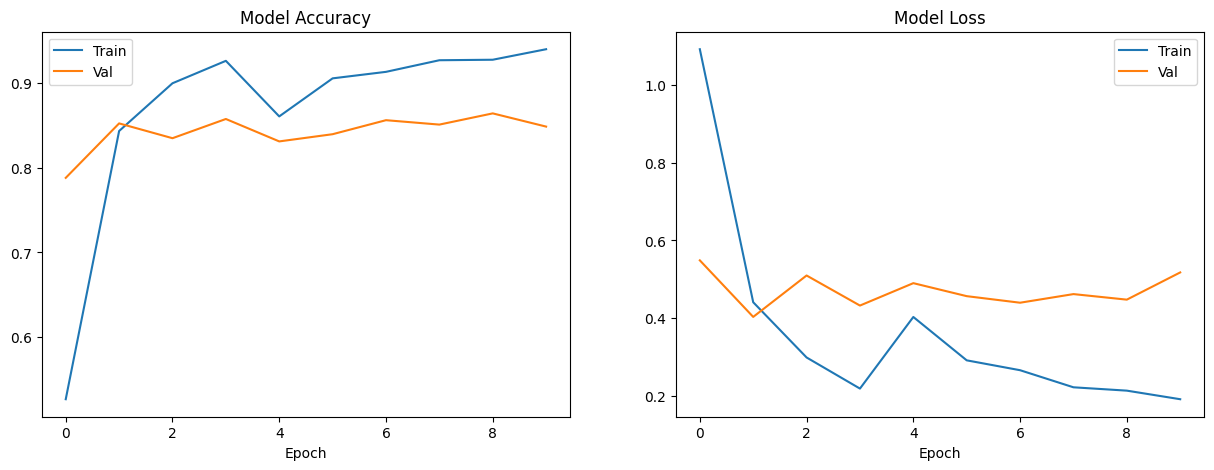

In [100]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc')

4146


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ (None, 32, 100)        │       463,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_42 (SimpleRNN)       │ (None, 32, 128)        │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_43 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507,009 (1.93 MB)

 Trainable params: 507,009 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.2385 - f1_score: 0.2028 - loss: 1.5943 - val_accuracy: 0.5409 - val_f1_score: 0.4927 - val_loss: 1.0678
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6106 - f1_score: 0.6012 - loss: 0.9254 - val_accuracy: 0.7412 - val_f1_score: 0.7515 - val_loss: 0.6937
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8181 - f1_score: 0.8215 - loss: 0.4994 - val_accuracy: 0.7257 - val_f1_score: 0.7291 - val_loss: 0.6959
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8527 - f1_score: 0.8548 - loss: 0.3970 - val_accuracy: 0.7542 - val_f1_score: 0.7561 - val_loss: 0.6981
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8841 - f1_score: 0.8857 - loss: 0.3302 - val_accuracy: 0.8104 - val_f1_score: 0.8209 - val_loss: 0.5350
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9219 - f1_score: 0.9236 - loss: 0.2326 - val_accuracy: 0.8350 - val_f1

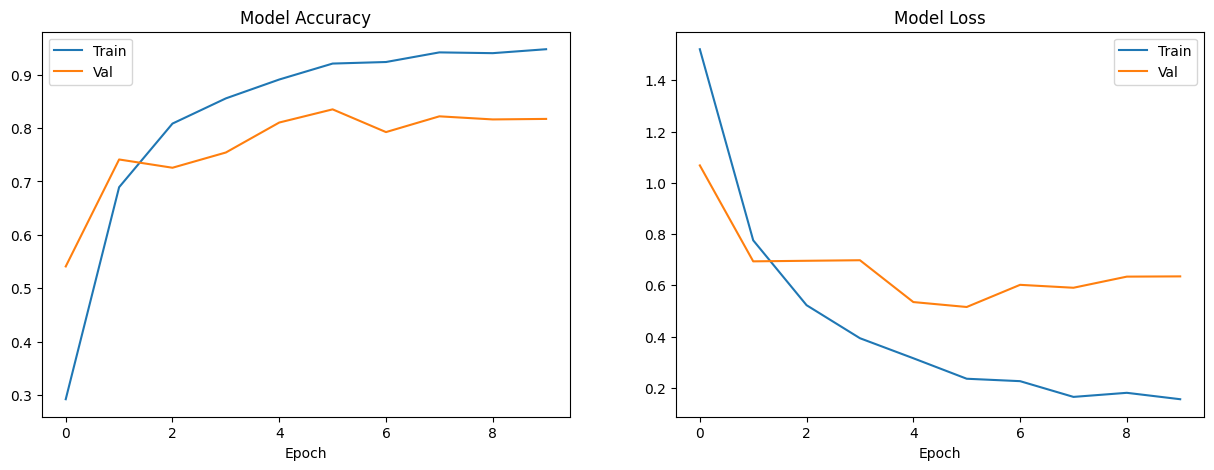

In [59]:
pad_train, pad_test = preprocessing_dl(vocab_size, 32 , train['User_input_preprocessed'], test['User_input_preprocessed'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc')

4146


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 64, 100)        │       463,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_44 (SimpleRNN)       │ (None, 64, 128)        │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_45 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507,009 (1.93 MB)

 Trainable params: 507,009 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.3283 - f1_score: 0.3099 - loss: 1.4559 - val_accuracy: 0.6609 - val_f1_score: 0.6679 - val_loss: 0.7947
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.6894 - f1_score: 0.6908 - loss: 0.7496 - val_accuracy: 0.6057 - val_f1_score: 0.6173 - val_loss: 0.9698
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7229 - f1_score: 0.7270 - loss: 0.7107 - val_accuracy: 0.7992 - val_f1_score: 0.8106 - val_loss: 0.5617
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8321 - f1_score: 0.8385 - loss: 0.4516 - val_accuracy: 0.7634 - val_f1_score: 0.7649 - val_loss: 0.6540
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8485 - f1_score: 0.8538 - loss: 0.3953 - val_accuracy: 0.8321 - val_f1_score: 0.8401 - val_loss: 0.4638
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9044 - f1_score: 0.9065 - loss: 0.2741 - val_accuracy: 0.8307 - val

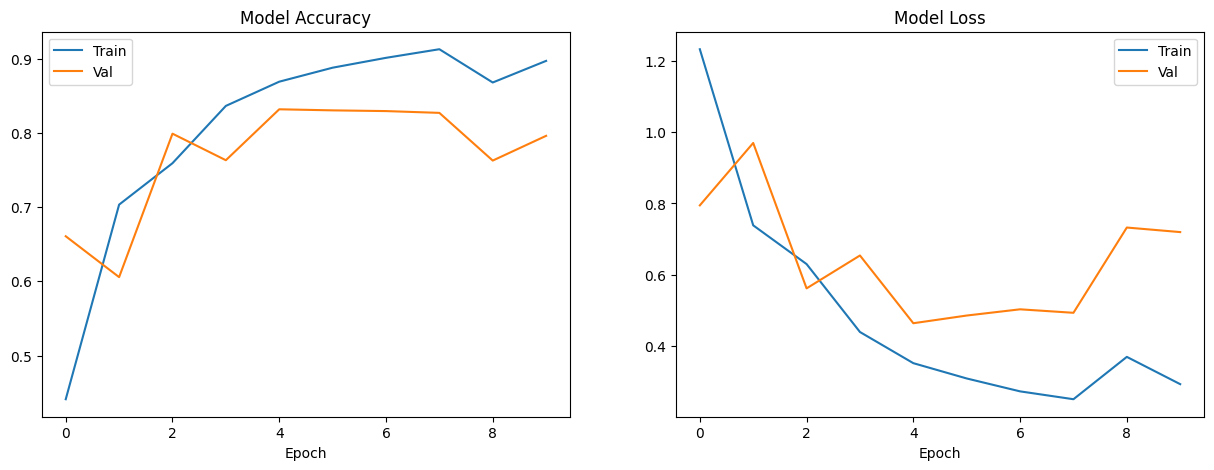

In [60]:
pad_train, pad_test = preprocessing_dl(vocab_size, 64 , train['User_input_preprocessed'], test['User_input_preprocessed'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc')

4146


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ (None, 128, 100)       │       463,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_46 (SimpleRNN)       │ (None, 128, 128)       │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_47 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507,009 (1.93 MB)

 Trainable params: 507,009 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - accuracy: 0.2236 - f1_score: 0.1997 - loss: 1.6093 - val_accuracy: 0.4422 - val_f1_score: 0.4295 - val_loss: 1.3389
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.5461 - f1_score: 0.5393 - loss: 1.1144 - val_accuracy: 0.7088 - val_f1_score: 0.7084 - val_loss: 0.7351
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 27s 51ms/step - accuracy: 0.8172 - f1_score: 0.8179 - loss: 0.4793 - val_accuracy: 0.7605 - val_f1_score: 0.7576 - val_loss: 0.6632
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.8607 - f1_score: 0.8633 - loss: 0.3658 - val_accuracy: 0.8060 - val_f1_score: 0.8131 - val_loss: 0.5176
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.7996 - f1_score: 0.8037 - loss: 0.5261 - val_accuracy: 0.8152 - val_f1_score: 0.8243 - val_loss: 0.5435
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.8693 - f1_score: 0.8736 - loss: 0.3619 - val_accuracy: 0.7968 - val

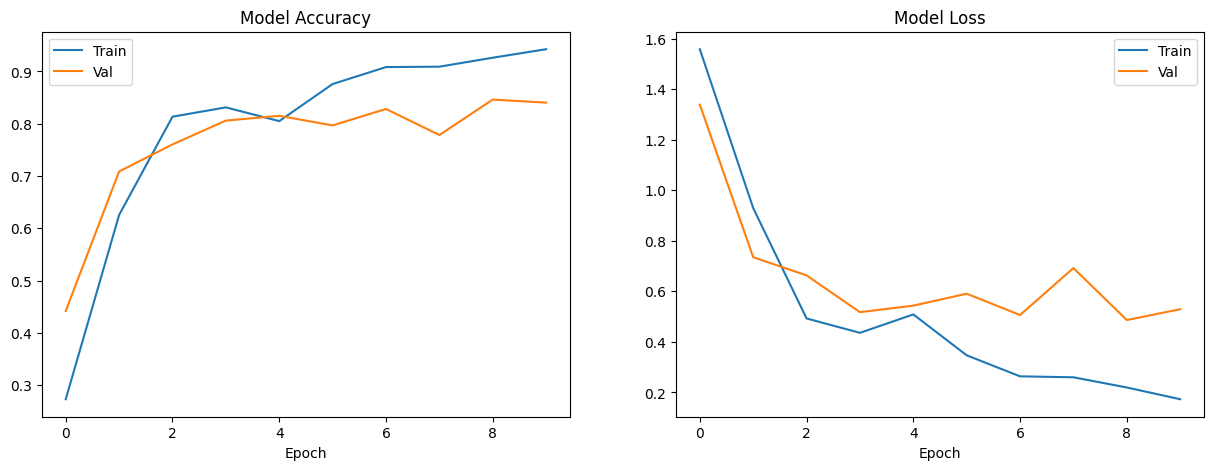

In [61]:
pad_train, pad_test = preprocessing_dl(vocab_size, 128 , train['User_input_preprocessed'], test['User_input_preprocessed'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc')

4146


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ (None, 128, 200)       │       926,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_48 (SimpleRNN)       │ (None, 128, 128)       │        42,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_49 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 982,909 (3.75 MB)

 Trainable params: 982,909 (3.75 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.2434 - f1_score: 0.2305 - loss: 1.6124 - val_accuracy: 0.3614 - val_f1_score: 0.3255 - val_loss: 1.4123
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.6064 - f1_score: 0.5996 - loss: 0.9706 - val_accuracy: 0.4359 - val_f1_score: 0.3245 - val_loss: 2.1455
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - accuracy: 0.7489 - f1_score: 0.7501 - loss: 0.6759 - val_accuracy: 0.7828 - val_f1_score: 0.7845 - val_loss: 0.5778
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.8760 - f1_score: 0.8795 - loss: 0.3584 - val_accuracy: 0.8094 - val_f1_score: 0.8202 - val_loss: 0.5446
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.9056 - f1_score: 0.9089 - loss: 0.2724 - val_accuracy: 0.8510 - val_f1_score: 0.8585 - val_loss: 0.4655
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.9373 - f1_score: 0.9392 - loss: 0.1913 - val_accuracy: 0.6720 - val

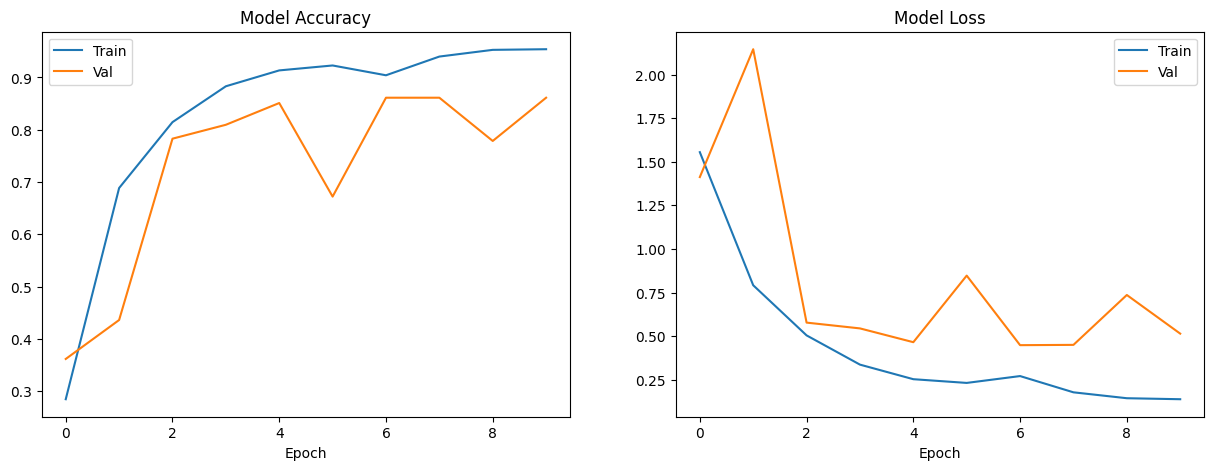

In [62]:
pad_train, pad_test = preprocessing_dl(vocab_size, 128 , train['User_input_preprocessed'], test['User_input_preprocessed'])

RNN_model(200, vocab_size, pad_train, pad_test, 'withproc')

##### With Lemmatization

In [101]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

Number of unique words: 4449
Max length: 58


4040


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)        │ (None, 58, 100)        │       444,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_56 (SimpleRNN)       │ (None, 58, 128)        │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_57 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 488,809 (1.86 MB)

 Trainable params: 488,809 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.2262 - f1_score: 0.2135 - loss: 1.5989 - val_accuracy: 0.6190 - val_f1_score: 0.6205 - val_loss: 0.9688
Epoch 2/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.7220 - f1_score: 0.7219 - loss: 0.7080 - val_accuracy: 0.7676 - val_f1_score: 0.7684 - val_loss: 0.6039
Epoch 3/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.8671 - f1_score: 0.8692 - loss: 0.3631 - val_accuracy: 0.8350 - val_f1_score: 0.8400 - val_loss: 0.4683
Epoch 4/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.8964 - f1_score: 0.8999 - loss: 0.2869 - val_accuracy: 0.8175 - val_f1_score: 0.8221 - val_loss: 0.4893
Epoch 5/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9166 - f1_score: 0.9189 - loss: 0.2448 - val_accuracy: 0.7921 - val_f1_score: 0.7965 - val_loss: 0.5561
Epoch 6/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.9396 - f1_score: 0.9408 - loss: 0.1781 - val_accuracy: 0.8265 - val

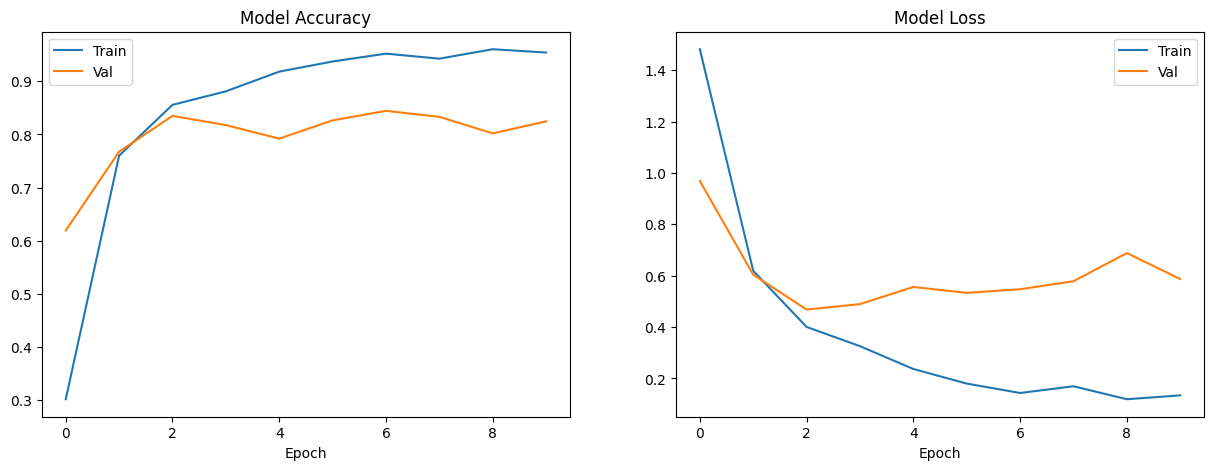

In [102]:
pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc_lem')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, 32 , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc_lem')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, 64 , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc_lem')

In [ ]:
pad_train, pad_test = preprocessing_dl(vocab_size, 128 , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc_lem')

##### With Stemming

In [103]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

Number of unique words: 3702
Max length: 58


3462


Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)        │ (None, 58, 100)        │       370,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_58 (SimpleRNN)       │ (None, 58, 128)        │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_59 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,109 (1.58 MB)

 Trainable params: 414,109 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.2148 - f1_score: 0.2046 - loss: 1.6386 - val_accuracy: 0.2084 - val_f1_score: 0.0788 - val_loss: 1.6124
Epoch 2/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.2001 - f1_score: 0.1785 - loss: 1.6230 - val_accuracy: 0.2041 - val_f1_score: 0.0678 - val_loss: 1.6099
Epoch 3/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.2189 - f1_score: 0.1836 - loss: 1.6244 - val_accuracy: 0.2098 - val_f1_score: 0.0694 - val_loss: 1.6306
Epoch 4/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.2152 - f1_score: 0.1668 - loss: 1.6167 - val_accuracy: 0.2084 - val_f1_score: 0.0690 - val_loss: 1.6063
Epoch 5/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.2106 - f1_score: 0.1802 - loss: 1.6086 - val_accuracy: 0.2640 - val_f1_score: 0.1448 - val_loss: 1.5839
Epoch 6/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.2394 - f1_score: 0.2267 - loss: 1.6166 - val_accuracy: 0.3583 - val

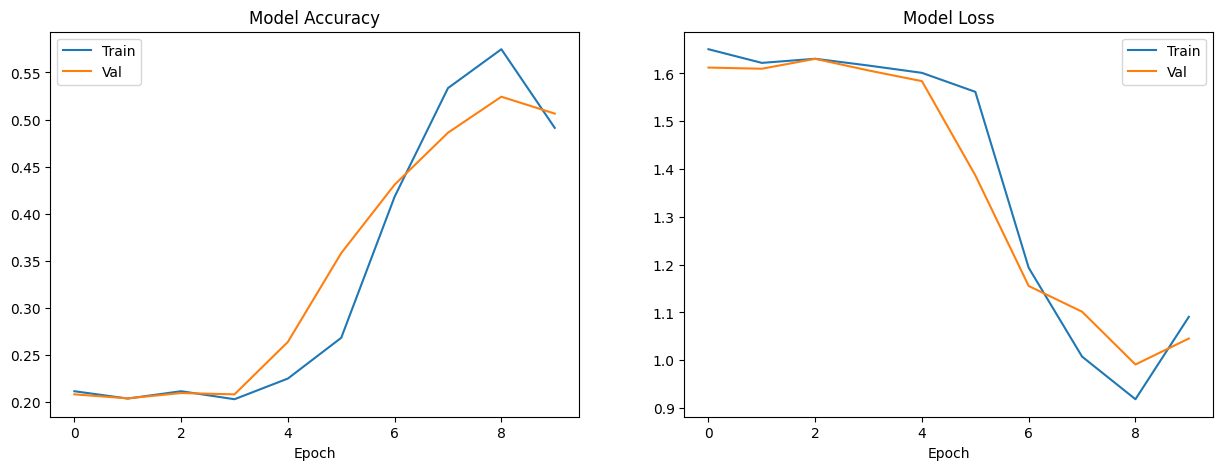

In [104]:

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc_stem')

In [ ]:

pad_train, pad_test = preprocessing_dl(vocab_size, 32 , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc_stem')

In [ ]:

pad_train, pad_test = preprocessing_dl(vocab_size, 64 , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc_stem')

In [ ]:

pad_train, pad_test = preprocessing_dl(vocab_size, 128 , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

RNN_model(100, vocab_size, pad_train, pad_test, 'withproc_stem')

#### Conv 1D

In [54]:
def Conv1D_model(use_embedding,vocab_size,pad_train,pad_test,proc_type):
    embedding_dim = 100

    # Create Conv1D model for text classification
    conv1d = Sequential(name="Conv1D")
    if use_embedding:
        conv1d.add(Embedding(vocab_size, embedding_dim))
    else: 
        conv1d.add(Dense(256, activation='relu', input_dim=vocab_size))
        conv1d.add(Reshape((-1, 1)))  
    conv1d.add(Conv1D(128,4))
    conv1d.add(GlobalMaxPooling1D())
    conv1d.add(Dense(32, activation='relu'))
    conv1d.add(Dense(5, activation='softmax'))

    conv1d.build(input_shape=(None, pad_train.shape[1]))

    print(conv1d.summary())

    conv1d.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = conv1d.fit(
        pad_train, 
        train_labels, 
        epochs=10,
        batch_size=12,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(conv1d, history, pad_test, test_labels)
    conv1d.save('Models/Conv1D/conv_'+ proc_type + '.keras')


##### Without Preprocessing

In [52]:
vocab_size_bow = len(bow_normal.vocabulary_)
vocab_size_bow_ngram = len(bow_ngram_normal.vocabulary_)
vocab_size_tfidf = len(tf_idf_normal.vocabulary_)
vocab_size_tfidf_ngram = len(tf_idf_ngram_normal.vocabulary_)

In [72]:
vocab_size, mean_length = analyse_data(data['User_input'])

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input'], test['User_input'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withoutproc')

Number of unique words: 4631
Mean length: 90
4146


TypeError: Conv1D_model() missing 1 required positional argument: 'proc_type'

In [ ]:
Conv1D_model(vocab_size_bow, X_train_bow_noproc, X_test_bow_noproc, 'withoutproc_bow')

In [ ]:
Conv1D_model(vocab_size_bow_ngram, X_train_ngram_noproc, X_test_ngram_noproc, 'withoutproc_bow_ngram')

In [ ]:
Conv1D_model(vocab_size_tfidf, X_train_tfidf_noproc, X_test_tfidf_noproc, 'withoutproc_tfidf')

In [ ]:
Conv1D_model(vocab_size_tfidf_ngram, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, 'withoutproc_tfidf_ngram')

##### With Preprocessing

In [56]:
vocab_size_bow = len(bow_preprocessed.vocabulary_)
vocab_size_bow_ngram = len(bow_ngram_preprocessed.vocabulary_)
vocab_size_tfidf = len(tf_idf_preprocessed.vocabulary_)
vocab_size_tfidf_ngram = len(tf_idf_ngram_preprocessed.vocabulary_)

In [73]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

Conv1D_model(True, vocab_size, pad_train, pad_test, 'withproc')

Number of unique words: 2970
Mean length: 62
2731


Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 62, 2970)       │     8,820,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 59, 256)        │     3,041,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 59, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 59, 32)         │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,899,625 (45.39 MB)

 Trainable params: 11,899,625 (45.39 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
484/689 ━━━━━━━━━━━━━━━━━━━━ 50s 245ms/step - accuracy: 0.7110 - loss: 0.7276

KeyboardInterrupt: 

In [96]:
Conv1D_model(vocab_size_bow, X_train_bow_proc, X_test_bow_proc, 'withproc_bow')

Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 1893, 300)      │       567,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 1889, 128)      │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_12         │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 764,321 (2.92 MB)

 Trainable params: 764,321 (2.92 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 214s 821ms/step - accuracy: 0.2082 - loss: 1.6093 - val_accuracy: 0.2182 - val_loss: 1.6041
Epoch 2/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 228s 879ms/step - accuracy: 0.2153 - loss: 1.6025 - val_accuracy: 0.2172 - val_loss: 1.5954
Epoch 3/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 246s 948ms/step - accuracy: 0.2165 - loss: 1.5979 - val_accuracy: 0.2308 - val_loss: 1.5929
Epoch 4/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 246s 950ms/step - accuracy: 0.2281 - loss: 1.5949 - val_accuracy: 0.2313 - val_loss: 1.5904
Epoch 5/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 248s 956ms/step - accuracy: 0.2315 - loss: 1.5880 - val_accuracy: 0.2284 - val_loss: 1.5906
Epoch 6/10
213/259 ━━━━━━━━━━━━━━━━━━━━ 40s 887ms/step - accuracy: 0.2298 - loss: 1.5867

In [80]:
Conv1D_model(vocab_size_bow_ngram, X_train_ngram_proc, X_test_ngram_proc, 'withproc_bow_ngram')

Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 3000, 300)      │       900,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 2996, 128)      │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,100,709 (4.20 MB)

 Trainable params: 1,100,709 (4.20 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
 56/259 ━━━━━━━━━━━━━━━━━━━━ 5:49 2s/step - accuracy: 0.2219 - loss: 1.6093

KeyboardInterrupt: 

In [ ]:
Conv1D_model(vocab_size_tfidf, X_train_tfidf_proc, X_test_tfidf_proc, 'withproc_tfidf')

In [ ]:
Conv1D_model(vocab_size_tfidf_ngram, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, 'withproc_tfidf_ngram')

##### With Lemmatization

In [ ]:
vocab_size_bow = len(bow_lem.vocabulary_)
vocab_size_bow_ngram = len(bow_ngram_lem.vocabulary_)
vocab_size_tfidf = len(tf_idf_lem.vocabulary_)
vocab_size_tfidf_ngram = len(tf_idf_ngram_lem.vocabulary_)

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

pad_train, pad_test = preprocessing_dl(mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

Conv1D_model(vocab_size, pad_train, pad_test, 'withproc_lem')

In [ ]:
Conv1D_model(vocab_size_bow, X_train_bow_lem, X_test_bow_lem, 'withproc_lem_bow')

In [ ]:
Conv1D_model(vocab_size_bow_ngram, X_train_ngram_lem, X_test_ngram_lem, 'withproc_lem_bow_ngram')

In [ ]:
Conv1D_model(vocab_size_tfidf, X_train_tfidf_lem, X_test_tfidf_lem, 'withproc_lem_tfidf')

In [ ]:
Conv1D_model(vocab_size_tfidf_ngram, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, 'withproc_lem_tfidf_ngram')

##### With Stemming

In [55]:
vocab_size_bow = len(bow_stem.vocabulary_)
vocab_size_bow_ngram = len(bow_ngram_stem.vocabulary_)
vocab_size_tfidf = len(tf_idf_stem.vocabulary_)
vocab_size_tfidf_ngram = len(tf_idf_ngram_stem.vocabulary_)

Number of unique words: 2016
Mean length: 52
1887


Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 52, 100)        │       201,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 49, 128)        │        51,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,221 (1004.77 KB)

 Trainable params: 257,221 (1004.77 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6591 - loss: 0.8789 - val_accuracy: 0.8699 - val_loss: 0.3511
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9100 - loss: 0.2481 - val_accuracy: 0.8679 - val_loss: 0.3339
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9448 - loss: 0.1580 - val_accuracy: 0.8665 - val_loss: 0.3539
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9637 - loss: 0.1034 - val_accuracy: 0.8674 - val_loss: 0.3829
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9798 - loss: 0.0632 - val_accuracy: 0.8655 - val_loss: 0.4439
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9852 - loss: 0.0426 - val_accuracy: 0.8621 - val_loss: 0.5110
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9915 - loss: 0.0258 - val_accuracy: 0.8636 - val_loss: 0.5636
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9918 - loss: 0.0233 - val_accurac

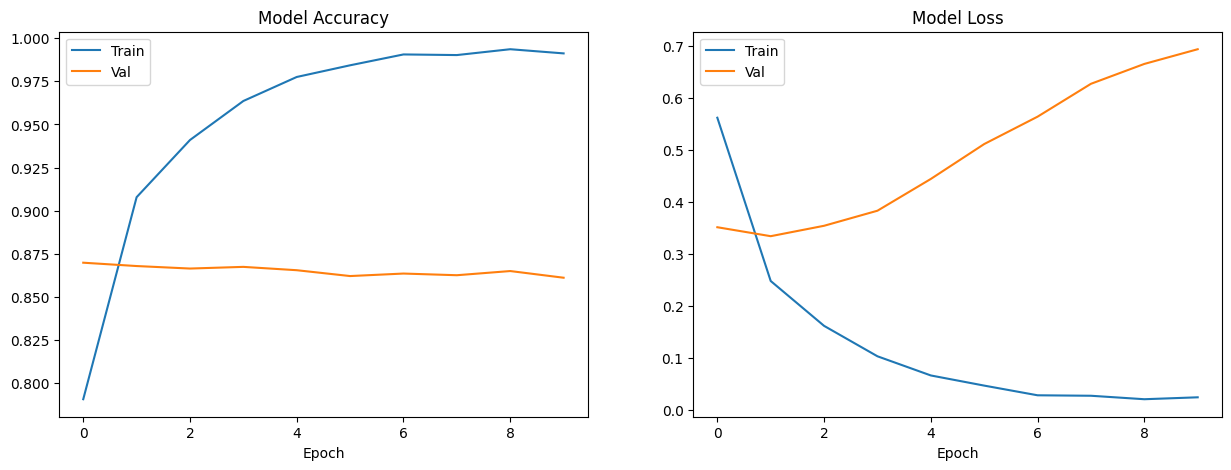

In [57]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

Conv1D_model(True, vocab_size, pad_train, pad_test, 'withproc_stem')

Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 256)            │       484,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 253, 128)       │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,797 (1.87 MB)

 Trainable params: 489,797 (1.87 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4043 - loss: 1.3149 - val_accuracy: 0.8258 - val_loss: 0.4945
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8818 - loss: 0.3617 - val_accuracy: 0.8452 - val_loss: 0.4029
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9249 - loss: 0.2182 - val_accuracy: 0.8597 - val_loss: 0.3897
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9559 - loss: 0.1406 - val_accuracy: 0.8582 - val_loss: 0.4209
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9656 - loss: 0.1107 - val_accuracy: 0.8462 - val_loss: 0.4819
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9776 - loss: 0.0760 - val_accuracy: 0.8476 - val_loss: 0.5299
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9857 - loss: 0.0496 - val_accuracy: 0.8520 - val_loss: 0.6152
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9844 - loss: 0.0479 - va

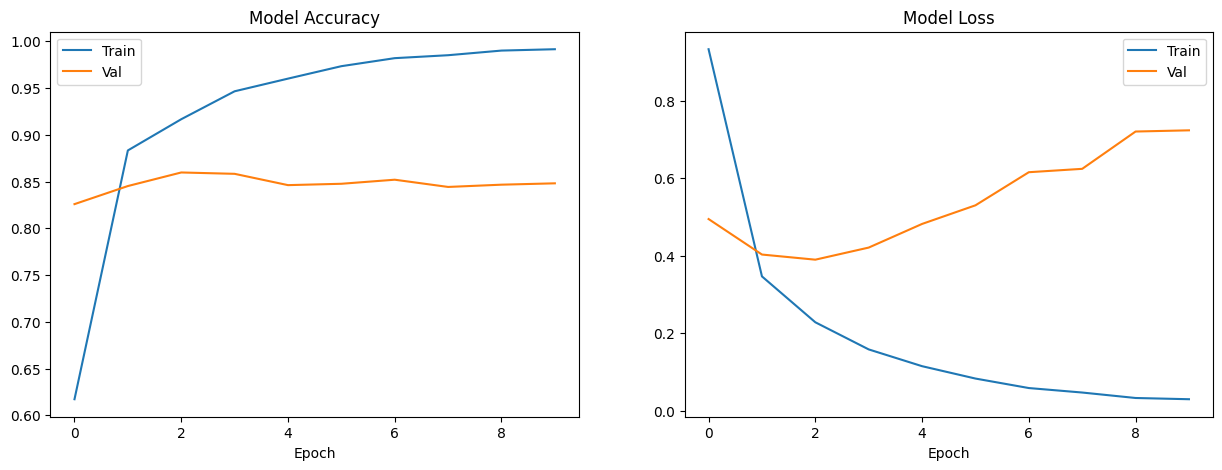

In [58]:
Conv1D_model(False, vocab_size_bow, X_train_bow_stem, X_test_bow_stem, 'withproc_stem_bow')

In [60]:
Conv1D_model(False, vocab_size_bow_ngram, X_train_ngram_stem, X_test_ngram_stem, 'withproc_stem_bow_ngram')

Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │    14,122,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 253, 128)       │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,127,685 (53.89 MB)

 Trainable params: 14,127,685 (53.89 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 131s 187ms/step - accuracy: 0.4832 - loss: 1.1672 - val_accuracy: 0.8244 - val_loss: 0.4930
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 134s 194ms/step - accuracy: 0.9057 - loss: 0.3321 - val_accuracy: 0.8500 - val_loss: 0.4720
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 142s 205ms/step - accuracy: 0.9669 - loss: 0.1095 - val_accuracy: 0.8312 - val_loss: 0.5759
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 137s 199ms/step - accuracy: 0.9864 - loss: 0.0994 - val_accuracy: 0.8408 - val_loss: 0.5653
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 128s 186ms/step - accuracy: 0.9923 - loss: 0.0304 - val_accuracy: 0.8142 - val_loss: 0.6709
Epoch 6/10
481/689 ━━━━━━━━━━━━━━━━━━━━ 36s 177ms/step - accuracy: 0.9935 - loss: 0.0206

KeyboardInterrupt: 

In [ ]:
Conv1D_model(vocab_size_tfidf, X_train_tfidf_stem, X_test_tfidf_stem, 'withproc_stem_tfidf')

In [ ]:
Conv1D_model(vocab_size_tfidf_ngram, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, 'withproc_stem_tfidf_ngram')

#### LSTM

In [117]:
def LSTM_model(vocab_size,pad_train,pad_test,proc_type):
    embedding_dim = 60

    # Create LSTM model for text classification
    lstm = Sequential(name="LSTM")
    lstm.add(Embedding(vocab_size, embedding_dim))
    lstm.add(LSTM(32))
    lstm.add(Dropout(0.4))
    lstm.add(Dense(5, activation='softmax'))

    lstm.build(input_shape=(None, pad_train.shape[1]))

    print(lstm.summary())

    lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = lstm.fit(
        pad_train, 
        train_labels, 
        epochs=10,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(lstm, history, pad_test, test_labels)
    lstm.save('Models/LSTM/LSTM_'+ proc_type + '.keras')

**Without Preprocessing**

In [ ]:
vocab_size_bow = len(bow_normal.vocabulary_)
vocab_size_bow_ngram = len(bow_ngram_normal.vocabulary_)
vocab_size_tfidf = len(tf_idf_normal.vocabulary_)
vocab_size_tfidf_ngram = len(tf_idf_ngram_normal.vocabulary_)

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input'])

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input'], test['User_input'])

LSTM_model(vocab_size, pad_train, pad_test, 'withoutproc')

In [ ]:
LSTM_model(vocab_size_bow, X_train_bow_noproc, X_test_bow_noproc, 'withoutproc_bow')

In [ ]:
LSTM_model(vocab_size_bow_ngram, X_train_ngram_noproc, X_test_ngram_noproc, 'withoutproc_bow_ngram')

In [ ]:
LSTM_model(vocab_size_tfidf, X_train_tfidf_noproc, X_test_tfidf_noproc, 'withoutproc_tfidf')

In [ ]:
LSTM_model(vocab_size_tfidf_ngram, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, 'withoutproc_tfidf_ngram')

**With Preprocessing**

In [ ]:
vocab_size_bow = len(bow_preprocessed.vocabulary_)
vocab_size_bow_ngram = len(bow_ngram_preprocessed.vocabulary_)
vocab_size_tfidf = len(tf_idf_preprocessed.vocabulary_)
vocab_size_tfidf_ngram = len(tf_idf_ngram_preprocessed.vocabulary_)

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc')

In [ ]:
LSTM_model(vocab_size_bow, X_train_bow_proc, X_test_bow_proc, 'withproc_bow')

In [ ]:
LSTM_model(vocab_size_bow_ngram, X_train_ngram_proc, X_test_ngram_proc, 'withproc_bow_ngram')

In [ ]:
LSTM_model(vocab_size_tfidf, X_train_tfidf_proc, X_test_tfidf_proc, 'withproc_tfidf')

In [ ]:
LSTM_model(vocab_size_tfidf_ngram, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, 'withproc_tfidf_ngram')

**With Lemmatization**

In [ ]:
vocab_size_bow = len(bow_lem.vocabulary_)
vocab_size_bow_ngram = len(bow_ngram_lem.vocabulary_)
vocab_size_tfidf = len(tf_idf_lem.vocabulary_)
vocab_size_tfidf_ngram = len(tf_idf_ngram_lem.vocabulary_)

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc_lem')

In [ ]:
LSTM_model(vocab_size_bow, X_train_bow_lem, X_test_bow_lem, 'withproc_lem_bow')

In [ ]:
LSTM_model(vocab_size_bow_ngram, X_train_ngram_lem, X_test_ngram_lem, 'withproc_lem_bow_ngram')

In [ ]:
LSTM_model(vocab_size_tfidf, X_train_tfidf_lem, X_test_tfidf_lem, 'withproc_lem_tfidf')

In [ ]:
LSTM_model(vocab_size_tfidf_ngram, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, 'withproc_lem_tfidf_ngram')

**With Stemming**

In [ ]:
vocab_size_bow = len(bow_stem.vocabulary_)
vocab_size_bow_ngram = len(bow_ngram_stem.vocabulary_)
vocab_size_tfidf = len(tf_idf_stem.vocabulary_)
vocab_size_tfidf_ngram = len(tf_idf_ngram_stem.vocabulary_)

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

LSTM_model(vocab_size, pad_train, pad_test, 'withproc_stem')

In [ ]:
LSTM_model(vocab_size_bow, X_train_bow_stem, X_test_bow_stem, 'withproc_stem_bow')

In [ ]:
LSTM_model(vocab_size_bow_ngram, X_train_ngram_stem, X_test_ngram_stem, 'withproc_stem_bow_ngram')

In [ ]:
LSTM_model(vocab_size_tfidf, X_train_tfidf_stem, X_test_tfidf_stem, 'withproc_stem_tfidf')

In [ ]:
LSTM_model(vocab_size_tfidf_ngram, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, 'withproc_stem_tfidf_ngram')

#### BILSTM

In [124]:
def BiLSTM_model(vocab_size,pad_train,pad_test,proc_type):
    embedding_dim = 60

    # Create LSTM model for text classification
    blstm = Sequential(name="Bi_LSTM")
    blstm.add(Embedding(vocab_size, embedding_dim))
    blstm.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
    blstm.add(Dropout(0.4))
    blstm.add(Bidirectional(LSTM(32)))
    blstm.add(Dropout(0.2))
    blstm.add(Dense(64, activation='relu'))
    blstm.add(Dropout(0.1))
    blstm.add(Dense(5, activation='softmax'))

    blstm.build(input_shape=(None, pad_train.shape[1]))

    print(blstm.summary())

    blstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = blstm.fit(
        pad_train, 
        train_labels, 
        epochs=10,
        validation_data=(pad_test, test_labels))
    
    evaluate_dp(blstm, history, pad_test, test_labels)
    blstm.save('Models/BILSTM/BILSTM_'+ proc_type + '.keras')

**Without Preprocessing**

In [ ]:
vocab_size_bow = len(bow_normal.vocabulary_)
vocab_size_bow_ngram = len(bow_ngram_normal.vocabulary_)
vocab_size_tfidf = len(tf_idf_normal.vocabulary_)
vocab_size_tfidf_ngram = len(tf_idf_ngram_normal.vocabulary_)

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input'])

pad_train, pad_test = preprocessing_dl( vocab_size, mean_length , train['User_input'], test['User_input'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withoutproc')

In [ ]:
BiLSTM_model(vocab_size_bow, X_train_bow_noproc, X_test_bow_noproc, 'withoutproc_bow')

In [ ]:
BiLSTM_model(vocab_size_bow_ngram, X_train_ngram_noproc, X_test_ngram_noproc, 'withoutproc_bow_ngram')

In [ ]:
BiLSTM_model(vocab_size_tfidf, X_train_tfidf_noproc, X_test_tfidf_noproc, 'withoutproc_tfidf')

In [ ]:
BiLSTM_model(vocab_size_tfidf_ngram, X_train_tfidf_ngram_noproc, X_test_tfidf_ngram_noproc, 'withoutproc_tfidf_ngram')

**With Preprocessing**

In [ ]:
vocab_size_bow = len(bow_preprocessed.vocabulary_)
vocab_size_bow_ngram = len(bow_ngram_preprocessed.vocabulary_)
vocab_size_tfidf = len(tf_idf_preprocessed.vocabulary_)
vocab_size_tfidf_ngram = len(tf_idf_ngram_preprocessed.vocabulary_)

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed'])

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed'], test['User_input_preprocessed'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc')

In [ ]:
BiLSTM_model(vocab_size_bow, X_train_bow_proc, X_test_bow_proc, 'withproc_bow')

In [ ]:
BiLSTM_model(vocab_size_bow_ngram, X_train_ngram_proc, X_test_ngram_proc, 'withproc_bow_ngram')

In [ ]:
BiLSTM_model(vocab_size_tfidf, X_train_tfidf_proc, X_test_tfidf_proc, 'withproc_tfidf')

In [ ]:
BiLSTM_model(vocab_size_tfidf_ngram, X_train_tfidf_ngram_proc, X_test_tfidf_ngram_proc, 'withproc_tfidf_ngram')

**With Lemmatization**

In [ ]:
vocab_size_bow = len(bow_lem.vocabulary_)
vocab_size_bow_ngram = len(bow_ngram_lem.vocabulary_)
vocab_size_tfidf = len(tf_idf_lem.vocabulary_)
vocab_size_tfidf_ngram = len(tf_idf_ngram_lem.vocabulary_)

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_lem'])

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_lem'], test['User_input_preprocessed_lem'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc_lem')

In [ ]:
BiLSTM_model(vocab_size_bow, X_train_bow_lem, X_test_bow_lem, 'withproc_lem_bow')

In [ ]:
BiLSTM_model(vocab_size_bow_ngram, X_train_ngram_lem, X_test_ngram_lem, 'withproc_lem_bow_ngram')

In [ ]:
BiLSTM_model(vocab_size_tfidf, X_train_tfidf_lem, X_test_tfidf_lem, 'withproc_lem_tfidf')

In [ ]:
BiLSTM_model(vocab_size_tfidf_ngram, X_train_tfidf_ngram_lem, X_test_tfidf_ngram_lem, 'withproc_lem_tfidf_ngram')

**With Stemming**

In [ ]:
vocab_size_bow = len(bow_stem.vocabulary_)
vocab_size_bow_ngram = len(bow_ngram_stem.vocabulary_)
vocab_size_tfidf = len(tf_idf_stem.vocabulary_)
vocab_size_tfidf_ngram = len(tf_idf_ngram_stem.vocabulary_)

In [ ]:
vocab_size, mean_length = analyse_data(data['User_input_preprocessed_stem'])

pad_train, pad_test = preprocessing_dl(vocab_size, mean_length , train['User_input_preprocessed_stem'], test['User_input_preprocessed_stem'])

BiLSTM_model(vocab_size, pad_train, pad_test, 'withproc_stem')

In [ ]:
BiLSTM_model(vocab_size_bow, X_train_bow_stem, X_test_bow_stem, 'withproc_stem_bow')

In [ ]:
BiLSTM_model(vocab_size_bow_ngram, X_train_ngram_stem, X_test_ngram_stem, 'withproc_stem_bow_ngram')

In [ ]:
BiLSTM_model(vocab_size_tfidf, X_train_tfidf_stem, X_test_tfidf_stem, 'withproc_stem_tfidf')

In [ ]:
BiLSTM_model(vocab_size_tfidf_ngram, X_train_tfidf_ngram_stem, X_test_tfidf_ngram_stem, 'withproc_stem_tfidf_ngram')